In [ ]:
# Data Handling and Preprocessing
import os
import glob
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import zipfile
import matplotlib.pyplot as plt
import random
import pandas as pd

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.layers import (Input, Dense, Reshape, Flatten, Dropout,
                                     BatchNormalization, Conv2D, Conv2DTranspose,
                                     LeakyReLU, ReLU, Embedding, Concatenate, Activation)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Suppress TensorFlow warnings for cleaner output
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)


In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Path to the zip file in Google Drive
zip_path = '/content/drive/My Drive/HDA-PlasticSurgery3.zip'

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content')

data_dir = '/content/HDA-PlasticSurgery'
# List of surgery types
surgery_types = ['Eyebrow', 'Eyelid', 'Facelift', 'FacialBones', 'Nose']

# Desired image size
img_height, img_width = 128, 128  # Adjusted for consistency
img_shape = (img_height, img_width, 3)
def load_and_preprocess_images(data_dir, surgery_types, img_size=(128, 128)):
    before_images = []
    after_images = []
    labels = []

    for s_type in surgery_types:
        folder_path = os.path.join(data_dir, s_type)

        # Get all images in the folder
        all_images = sorted(glob.glob(os.path.join(folder_path, '*.jpg')))

        # Group images by their base ID
        pairs = {}
        for img_path in all_images:
            filename = os.path.basename(img_path)
            base_id = filename.split('_')[0]  # e.g., '01' from '01_a.jpg'
            suffix = filename.split('_')[1].split('.')[0]  # 'a' or 'b'

            if base_id not in pairs:
                pairs[base_id] = {}
            pairs[base_id][suffix] = img_path

        # Load images and append to lists
        for base_id, pair_paths in pairs.items():
            if 'a' in pair_paths and 'b' in pair_paths:
                try:
                    # Load after (a) and before (b) images
                    after_img = cv2.imread(pair_paths['a'])
                    before_img = cv2.imread(pair_paths['b'])

                    if after_img is None or before_img is None:
                        print(f"Error reading images for pair {base_id} in {s_type}. Skipping.")
                        continue

                    # Convert to RGB
                    after_img = cv2.cvtColor(after_img, cv2.COLOR_BGR2RGB)
                    before_img = cv2.cvtColor(before_img, cv2.COLOR_BGR2RGB)

                    # Resize images
                    after_img = cv2.resize(after_img, img_size)
                    before_img = cv2.resize(before_img, img_size)

                    # Normalize images to [0,1]
                    after_img = after_img.astype('float32') / 255.0
                    before_img = before_img.astype('float32') / 255.0

                    # Append to lists
                    after_images.append(after_img)
                    before_images.append(before_img)
                    labels.append(s_type)
                except Exception as e:
                    print(f"Error processing pair {base_id} in {s_type}: {e}")
            else:
                print(f"Incomplete pair for base_id: {base_id} in {s_type}")

    return np.array(before_images), np.array(after_images), np.array(labels)

# Load and preprocess images
before_images, after_images, labels = load_and_preprocess_images(data_dir, surgery_types, img_size=(img_height, img_width))

print(f"Total samples: {before_images.shape[0]}")
print(f"Image shape: {before_images.shape[1:]}")
# Encode labels as integers
type_to_idx = {st: i for i, st in enumerate(surgery_types)}
int_labels = np.array([type_to_idx[label] for label in labels])

# Split into train (90%), validation (5%), test (5%)
X_train_before, X_temp_before, X_train_after, X_temp_after, y_train, y_temp = train_test_split(
    before_images, after_images, int_labels, test_size=0.1, random_state=42, stratify=int_labels
)

X_val_before, X_test_before, X_val_after, X_test_after, y_val, y_test = train_test_split(
    X_temp_before, X_temp_after, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("Training set size:", X_train_before.shape, X_train_after.shape)
print("Validation set size:", X_val_before.shape, X_val_after.shape)
print("Test set size:", X_test_before.shape, X_test_after.shape)


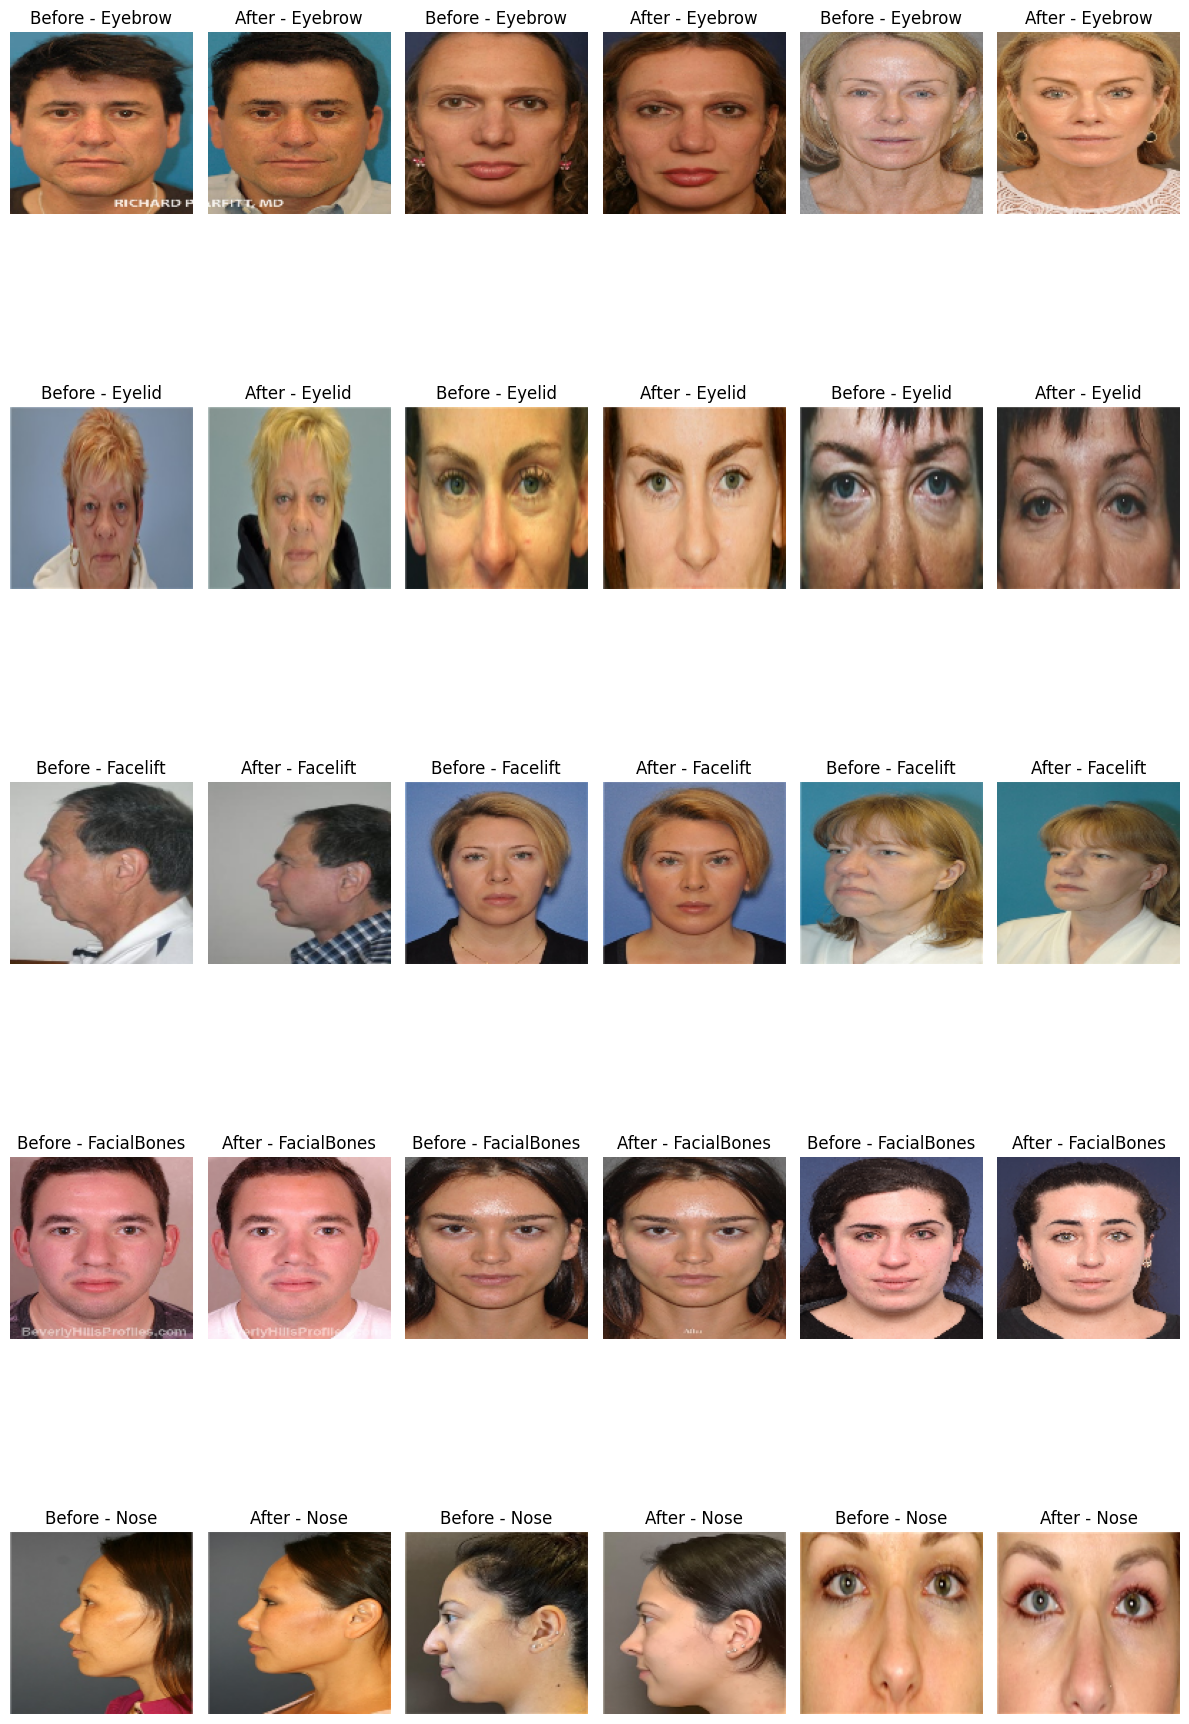

In [ ]:
def visualize_samples_per_type(X_before, X_after, y, type_to_idx, samples_per_type=3):
    """
    Visualizes multiple before-and-after image pairs for each surgery type.

    Parameters:
    - X_before: Numpy array of "before" images.
    - X_after: Numpy array of "after" images.
    - y: Numpy array of integer-encoded labels.
    - type_to_idx: Dictionary mapping surgery type names to integer labels.
    - samples_per_type: Number of samples to display per surgery type.
    """
    num_types = len(type_to_idx)
    surgery_types = list(type_to_idx.keys())

    fig, axes = plt.subplots(nrows=num_types, ncols=samples_per_type*2, figsize=(samples_per_type*4, num_types*4))

    for i, s_type in enumerate(surgery_types):
        label = type_to_idx[s_type]
        indices = np.where(y == label)[0]

        if len(indices) == 0:
            print(f"No samples found for surgery type: {s_type}")
            continue

        selected_indices = np.random.choice(indices, size=min(samples_per_type, len(indices)), replace=False)

        for j, idx in enumerate(selected_indices):
            # Before Image
            ax_before = axes[i, j*2] if num_types >1 else axes[j*2]
            ax_before.imshow(X_before[idx])
            ax_before.set_title(f"Before - {s_type}")
            ax_before.axis('off')

            # After Image
            ax_after = axes[i, j*2 +1] if num_types >1 else axes[j*2 +1]
            ax_after.imshow(X_after[idx])
            ax_after.set_title(f"After - {s_type}")
            ax_after.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize samples from the training set
visualize_samples_per_type(X_train_before, X_train_after, y_train, type_to_idx, samples_per_type=3)


In [ ]:
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
img_height, img_width = 128, 128  # Adjusted for consistency
img_shape = (img_height, img_width, 3)
surgery_types = ['Eyebrow', 'Eyelid', 'Facelift', 'FacialBones', 'Nose']
def build_cnn_classifier(img_shape, num_classes):
    """
    Builds a CNN classifier model.

    Parameters:
    - img_shape: Tuple representing the shape of input images (height, width, channels).
    - num_classes: Number of classes for classification.

    Returns:
    - Compiled CNN classifier model.
    """
    model = Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=img_shape),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Example usage:
num_classes = len(surgery_types)

# Build the CNN classifier
classifier = build_cnn_classifier(img_shape, num_classes)
classifier.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       7,372,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,392,965 (28.20 MB)

 Trainable params: 7,392,965 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Define callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('cnn_classifier_model.keras', monitor='val_loss', save_best_only=True)

# Train the CNN classifier
history = classifier.fit(
    X_train_before, y_train,
    validation_data=(X_val_before, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, checkpoint]
)


Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.3917 - loss: 1.9353 - val_accuracy: 0.7231 - val_loss: 1.0956
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5932 - loss: 1.0691 - val_accuracy: 0.7308 - val_loss: 0.7910
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6255 - loss: 0.9249 - val_accuracy: 0.7538 - val_loss: 0.7244
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6555 - loss: 0.8433 - val_accuracy: 0.7692 - val_loss: 0.7009
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6728 - loss: 0.7863 - val_accuracy: 0.7000 - val_loss: 0.7093
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7005 - loss: 0.7175 - val_accuracy: 0.7692 - val_loss: 0.6064
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7031 - loss: 0.7503 - val_accuracy: 0.7846 - val_loss: 0.5806
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7600 - loss: 0.6284 - val_accuracy: 0.7846 - v

In [ ]:
# Evaluate on the test set
test_loss, test_acc = classifier.evaluate(X_test_before, y_test)
print(f"Test Accuracy: {test_acc*100:.2f}%")


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7133 - loss: 0.7869 
Test Accuracy: 71.54%


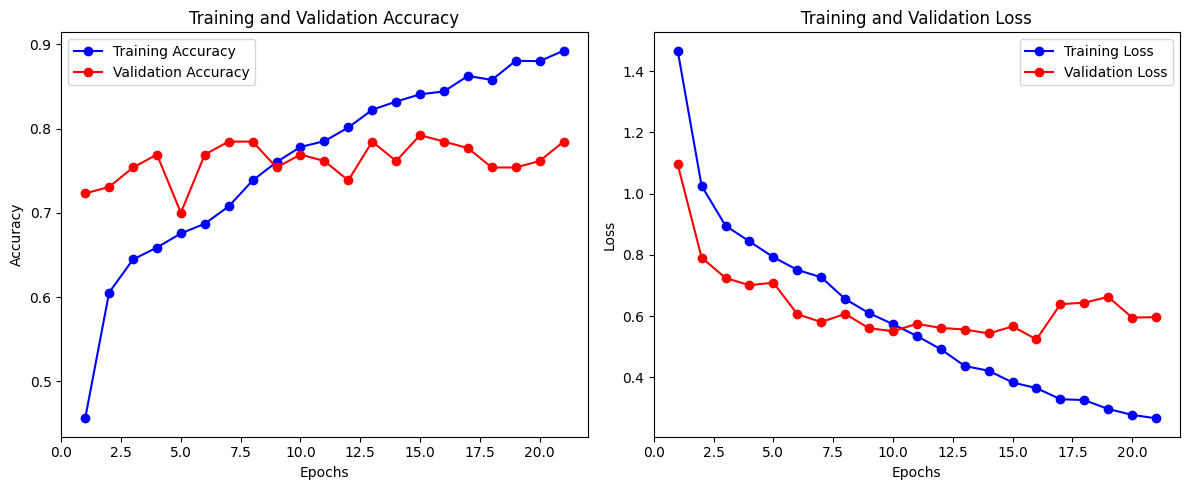

In [ ]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)


In [ ]:
num_types = len(surgery_types)
def build_enhanced_generator_conditional(img_shape, num_types):
    """
    Builds the Enhanced Generator model with surgery type conditioning.

    Parameters:
    - img_shape: Tuple representing the shape of input images (height, width, channels).
    - num_types: Number of surgery types.

    Returns:
    - Keras Model of the conditional generator.
    """
    # Image input
    input_img = Input(shape=img_shape, name='generator_input')

    # Surgery type input
    surgery_type = Input(shape=(1,), name='surgery_type')
    surgery_embedding = Embedding(num_types, 50, input_length=1)(surgery_type)
    surgery_embedding = Dense(img_shape[0] * img_shape[1], activation='relu')(surgery_embedding)
    surgery_embedding = Reshape((img_shape[0], img_shape[1], 1))(surgery_embedding)

    # Concatenate image and label embeddings
    concatenated = Concatenate()([input_img, surgery_embedding])

    # Encoder
    x = Conv2D(64, kernel_size=7, padding='same')(concatenated)
    x = ReLU()(x)
    x = BatchNormalization()(x)

    x = Conv2D(128, kernel_size=4, strides=2, padding='same')(x)
    x = ReLU()(x)
    x = BatchNormalization()(x)

    x = Conv2D(256, kernel_size=4, strides=2, padding='same')(x)
    x = ReLU()(x)
    x = BatchNormalization()(x)

    # Decoder
    x = Conv2DTranspose(128, kernel_size=4, strides=2, padding='same')(x)
    x = ReLU()(x)
    x = BatchNormalization()(x)

    x = Conv2DTranspose(64, kernel_size=4, strides=2, padding='same')(x)
    x = ReLU()(x)
    x = BatchNormalization()(x)

    # Output layer
    x = Conv2D(3, kernel_size=7, padding='same')(x)
    output_img = Activation('tanh')(x)  # Output range [-1, 1]

    generator = Model(inputs=[input_img, surgery_type], outputs=output_img, name='ConditionalEnhancedGenerator')
    return generator

# Instantiate the generator
conditional_generator = build_enhanced_generator_conditional(img_shape, num_types)
conditional_generator.summary()


Model: "ConditionalEnhancedGenerator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ surgery_type (InputLayer) │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 1, 50)          │            250 │ surgery_type[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 1, 16384)       │        835,584 │ embedding_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ generator_input           │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_1 (Reshape)       │ (None, 128, 128, 1)    │              0 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 128, 128, 4)    │              0 │ generator_input[0][0], │
│ (Concatenate)             │                        │                │ reshape_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 128, 128, 64)   │         12,608 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_5 (ReLU)            │ (None, 128, 128, 64)   │              0 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 128, 128, 64)   │            256 │ re_lu_5[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 64, 64, 128)    │        131,200 │ batch_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_6 (ReLU)            │ (None, 64, 64, 128)    │              0 │ conv2d_7[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_6     │ (None, 64, 64, 128)    │            512 │ re_lu_6[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 32, 32, 256)    │        524,544 │ batch_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_7 (ReLU)            │ (None, 32, 32, 256)    │              0 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_7     │ (None, 32, 32, 256)    │          1,024 │ re_lu_7[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_2        │ (None, 64, 64, 128)    │        524,416 │ batch_normalization_7… │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_8 (ReLU)       

 Total params: 2,171,709 (8.28 MB)

 Trainable params: 2,170,429 (8.28 MB)

 Non-trainable params: 1,280 (5.00 KB)

In [ ]:
def build_discriminator_conditional(img_shape, num_types):
    """
    Builds the Discriminator model with surgery type conditioning.

    Parameters:
    - img_shape: Tuple representing the shape of input images (height, width, channels).
    - num_types: Number of surgery types.

    Returns:
    - Keras Model of the conditional discriminator.
    """
    # Image input
    input_img = Input(shape=img_shape, name='discriminator_input')

    # Surgery type input
    surgery_type = Input(shape=(1,), name='surgery_type')
    surgery_embedding = Embedding(num_types, 50, input_length=1)(surgery_type)
    surgery_embedding = Dense(img_shape[0] * img_shape[1], activation='relu')(surgery_embedding)
    surgery_embedding = Reshape((img_shape[0], img_shape[1], 1))(surgery_embedding)

    # Concatenate image and label embeddings
    concatenated = Concatenate()([input_img, surgery_embedding])

    # Discriminator network
    x = Conv2D(64, kernel_size=3, strides=2, padding='same')(concatenated)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)

    x = Conv2D(128, kernel_size=3, strides=2, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)

    x = Flatten()(x)
    x = Dense(1, activation='sigmoid')(x)  # Probability of being real

    discriminator = Model(inputs=[input_img, surgery_type], outputs=x, name='ConditionalDiscriminator')
    return discriminator

# Instantiate the discriminator
conditional_discriminator = build_discriminator_conditional(img_shape, num_types)
conditional_discriminator.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "ConditionalDiscriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ surgery_type (InputLayer) │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, 1, 50)          │            250 │ surgery_type[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 1, 16384)       │        835,584 │ embedding_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ discriminator_input       │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_2 (Reshape)       │ (None, 128, 128, 1)    │              0 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 128, 128, 4)    │              0 │ discriminator_input[0… │
│ (Concatenate)             │                        │                │ reshape_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 64, 64, 64)     │          2,368 │ concatenate_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu (LeakyReLU)   │ (None, 64, 64, 64)     │              0 │ conv2d_10[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_10    │ (None, 64, 64, 64)     │            256 │ leaky_re_lu[0][0]      │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_11 (Conv2D)        │ (None, 32, 32, 128)    │         73,856 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_1 (LeakyReLU) │ (None, 32, 32, 128)    │              0 │ conv2d_11[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_11    │ (None, 32, 32, 128)    │            512 │ leaky_re_lu_1[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 131072)         │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 1)              │        131,073 │ flatten_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,043,899 (3.98 MB)

 Trainable params: 1,043,515 (3.98 MB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

# Load VGG16 and define the feature extractor
vgg = VGG16(weights='imagenet', include_top=False, input_shape=img_shape)
vgg.trainable = False

# Extract features from a specific layer (e.g., 'block3_conv3')
perceptual_layer = 'block3_conv3'
perceptual_model = Model(inputs=vgg.input, outputs=vgg.get_layer(perceptual_layer).output)

# Define Perceptual Loss Function
def perceptual_loss(y_true, y_pred):
    """
    Computes the perceptual loss between true and predicted images.
    """
    # Rescale images from [-1,1] to [0,255] and preprocess for VGG16
    y_true_preprocessed = tf.keras.applications.vgg16.preprocess_input((y_true + 1.0) * 127.5)
    y_pred_preprocessed = tf.keras.applications.vgg16.preprocess_input((y_pred + 1.0) * 127.5)

    # Extract features
    y_true_features = perceptual_model(y_true_preprocessed)
    y_pred_features = perceptual_model(y_pred_preprocessed)

    # Compute mean absolute error between features
    return K.mean(K.abs(y_true_features - y_pred_features))


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
class ConditionalGAN(tf.keras.Model):
    def __init__(self, generator, discriminator, perceptual_model,
                 lambda_cycle=10.0, lambda_identity=5.0, lambda_perceptual=2.0):
        super(ConditionalGAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.perceptual_model = perceptual_model
        self.lambda_cycle = lambda_cycle
        self.lambda_identity = lambda_identity
        self.lambda_perceptual = lambda_perceptual

        # Define loss functions
        self.bce_loss = tf.keras.losses.BinaryCrossentropy()
        self.mae_loss = tf.keras.losses.MeanAbsoluteError()

    def compile(self, gen_optimizer, disc_optimizer):
        super(ConditionalGAN, self).compile()
        self.gen_optimizer = gen_optimizer
        self.disc_optimizer = disc_optimizer

    def train_step(self, data):
        before_images, after_images, labels = data

        # Labels for real and fake images
        real_labels = tf.ones((tf.shape(before_images)[0], 1))
        fake_labels = tf.zeros((tf.shape(before_images)[0], 1))

        with tf.GradientTape(persistent=True) as tape:
            # Generate fake after images
            fake_after = self.generator([before_images, labels], training=True)

            # Reconstruct before images
            reconstructed_before = self.generator([fake_after, labels], training=True)

            # Identity mapping (optional)
            same_after = self.generator([after_images, labels], training=True)

            # Discriminator predictions
            disc_real = self.discriminator([after_images, labels], training=True)
            disc_fake = self.discriminator([fake_after, labels], training=True)

            # Generator GAN loss
            gen_gan_loss = self.bce_loss(real_labels, disc_fake)

            # Discriminator loss
            disc_real_loss = self.bce_loss(real_labels, disc_real)
            disc_fake_loss = self.bce_loss(fake_labels, disc_fake)
            disc_loss = (disc_real_loss + disc_fake_loss) * 0.5

            # Cycle consistency loss
            cycle_loss = self.mae_loss(before_images, reconstructed_before)

            # Identity loss
            id_loss = self.mae_loss(after_images, same_after)

            # Perceptual loss
            perc_loss = perceptual_loss(after_images, fake_after)

            # Total generator loss
            total_gen_loss = gen_gan_loss + self.lambda_cycle * cycle_loss + \
                             self.lambda_identity * id_loss + self.lambda_perceptual * perc_loss

        # Calculate gradients
        generator_gradients = tape.gradient(total_gen_loss, self.generator.trainable_variables)
        discriminator_gradients = tape.gradient(disc_loss, self.discriminator.trainable_variables)

        # Update weights
        self.gen_optimizer.apply_gradients(zip(generator_gradients, self.generator.trainable_variables))
        self.disc_optimizer.apply_gradients(zip(discriminator_gradients, self.discriminator.trainable_variables))

        return {
            "gen_gan_loss": gen_gan_loss,
            "cycle_loss": cycle_loss,
            "identity_loss": id_loss,
            "perceptual_loss": perc_loss,
            "disc_loss": disc_loss,
            "total_gen_loss": total_gen_loss
        }


In [ ]:
# Instantiate the generator and discriminator
conditional_generator = build_enhanced_generator_conditional(img_shape, num_types)
conditional_discriminator = build_discriminator_conditional(img_shape, num_types)

# Instantiate the GAN
conditional_gan = ConditionalGAN(conditional_generator, conditional_discriminator, perceptual_model)

# Compile the GAN with optimizers
gen_optimizer = Adam(learning_rate=2e-4, beta_1=0.5)
disc_optimizer = Adam(learning_rate=2e-4, beta_1=0.5)

conditional_gan.compile(gen_optimizer=gen_optimizer, disc_optimizer=disc_optimizer)


In [ ]:
# Normalize images to [-1, 1]
X_train_before_norm = X_train_before * 2.0 - 1.0
X_train_after_norm = X_train_after * 2.0 - 1.0

# Convert labels to integer type if not already
y_train_int = y_train.astype('int32')

# Create TensorFlow dataset with labels
BUFFER_SIZE = X_train_before_norm.shape[0]
BATCH_SIZE = 32

train_dataset_conditional = tf.data.Dataset.from_tensor_slices((X_train_before_norm, X_train_after_norm, y_train_int))
train_dataset_conditional = train_dataset_conditional.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [ ]:
class ConditionalGANMonitor(tf.keras.callbacks.Callback):
    def __init__(self, generator, surgery_types, num_examples=5):
        super(ConditionalGANMonitor, self).__init__()
        self.generator = generator
        self.num_examples = num_examples
        self.surgery_types = surgery_types
        self.seed_before = tf.convert_to_tensor(X_test_before[:self.num_examples] * 2.0 - 1.0, dtype=tf.float32)  # Normalize
        self.seed_labels = y_test[:self.num_examples].reshape(-1, 1)
        self.seed_after = tf.convert_to_tensor(X_test_after[:self.num_examples] * 2.0 - 1.0, dtype=tf.float32)  # Normalize

    def on_epoch_end(self, epoch, logs=None):
        fake_after = self.generator.predict([self.seed_before, self.seed_labels], verbose=0)
        fake_after = (fake_after + 1.0) / 2.0  # Rescale to [0,1]
        seed_before = (self.seed_before.numpy() + 1.0) / 2.0
        seed_after = (self.seed_after.numpy() + 1.0) / 2.0

        fig, axs = plt.subplots(self.num_examples, 3, figsize=(12, 4 * self.num_examples))
        for i in range(self.num_examples):
            axs[i, 0].imshow(seed_before[i])
            axs[i, 0].set_title("Before")
            axs[i, 0].axis('off')

            axs[i, 1].imshow(fake_after[i])
            axs[i, 1].set_title("Generated After")
            axs[i, 1].axis('off')

            axs[i, 2].imshow(seed_after[i])
            axs[i, 2].set_title("Target After")
            axs[i, 2].axis('off')

        plt.tight_layout()
        plt.savefig(f"generated_images/epoch_{epoch+1}.png")
        plt.close()


In [ ]:
# Create directory to save generated images and checkpoints
os.makedirs('generated_images', exist_ok=True)
os.makedirs('checkpoints', exist_ok=True)

# Define checkpoint callbacks
checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join('checkpoints', 'conditional_gan_epoch_{epoch}.weights.h5'),
    save_weights_only=True,
    save_freq='epoch'  # Save every epoch
)


In [ ]:
# Instantiate the monitor callback
monitor_conditional = ConditionalGANMonitor(conditional_generator, surgery_types, num_examples=5)


In [ ]:
# Define the number of epochs
EPOCHS = 100  # Adjust as needed

# Start GAN training
conditional_gan.fit(
    train_dataset_conditional,
    epochs=EPOCHS,
    callbacks=[monitor_conditional, checkpoint_callback]  # Include any additional callbacks as needed
)

Epoch 1/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 59s 329ms/step - cycle_loss: 0.5625 - disc_loss: 0.0480 - gen_gan_loss: 7.4524 - identity_loss: 0.5944 - perceptual_loss: 232.1746 - total_gen_loss: 480.3989
Epoch 2/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 23s 319ms/step - cycle_loss: 0.3194 - disc_loss: 0.0146 - gen_gan_loss: 10.9512 - identity_loss: 0.3802 - perceptual_loss: 193.8633 - total_gen_loss: 403.7729
Epoch 3/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 23s 321ms/step - cycle_loss: 0.2501 - disc_loss: 0.0122 - gen_gan_loss: 12.7483 - identity_loss: 0.2691 - perceptual_loss: 180.8631 - total_gen_loss: 378.3206
Epoch 4/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 24s 324ms/step - cycle_loss: 0.2154 - disc_loss: 0.1299 - gen_gan_loss: 16.5383 - identity_loss: 0.2247 - perceptual_loss: 178.9771 - total_gen_loss: 377.7697
Epoch 5/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 23s 319ms/step - cycle_loss: 0.2113 - disc_loss: 0.3330 - gen_gan_loss: 14.6630 - identity_loss: 0.1862 - perceptual_loss: 180.2088 - total_gen_loss: 378.1248
Epoch 6/100

In [ ]:
#Evaluation
# Load the best CNN classifier
classifier.load_weights('cnn_classifier_model.keras')

# Predict on generated images
fake_after_images = conditional_generator.predict([X_test_before[:100] * 2.0 - 1.0, y_test[:100].reshape(-1, 1)])
fake_after_images = (fake_after_images + 1.0) / 2.0  # Rescale to [0,1]

# Evaluate using the classifier
fake_preds = classifier.predict(fake_after_images)
fake_labels_pred = np.argmax(fake_preds, axis=1)

# Compare with true labels
accuracy = np.mean(fake_labels_pred == y_test[:100])
print(f"Classifier Accuracy on Generated Images: {accuracy * 100:.2f}%")

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 264ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step
Classifier Accuracy on Generated Images: 72.00%


In [ ]:
# Assuming `conditional_generator` and `conditional_discriminator` are your trained models

# Create directories to save the models if they don't exist
os.makedirs('saved_models', exist_ok=True)

# Save the generator and discriminator models
conditional_generator.save('saved_models/conditional_generator.h5')
conditional_discriminator.save('saved_models/conditional_discriminator.h5')


In [ ]:
from tensorflow.keras.models import load_model

# Load the saved generator and discriminator models
conditional_generator = load_model('saved_models/conditional_generator.h5', compile=False)
conditional_discriminator = load_model('saved_models/conditional_discriminator.h5', compile=False)

# If you need to compile them (optional, not necessary for just generating images)
# conditional_generator.compile(...)
# conditional_discriminator.compile(...)


In [ ]:
# Normalize "before" test images to [-1, 1]
X_test_before_norm = X_test_before * 2.0 - 1.0


In [ ]:
import numpy as np

num_examples = 5  # Number of samples to visualize

# Randomly select indices for visualization
indices = np.random.choice(len(X_test_before_norm), size=num_examples, replace=False)

# Select the corresponding before and after images and labels
selected_before = X_test_before_norm[indices]
selected_after_real = X_test_after[indices]
selected_labels = y_test[indices]


In [ ]:
# Reshape labels if necessary (ensure they are in the shape (num_samples, 1))
selected_labels = selected_labels.reshape(-1, 1)

# Generate fake "after" images
fake_after = conditional_generator.predict([selected_before, selected_labels])

# Rescale the generated images from [-1, 1] to [0, 1] for visualization
fake_after_rescaled = (fake_after + 1.0) / 2.0


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


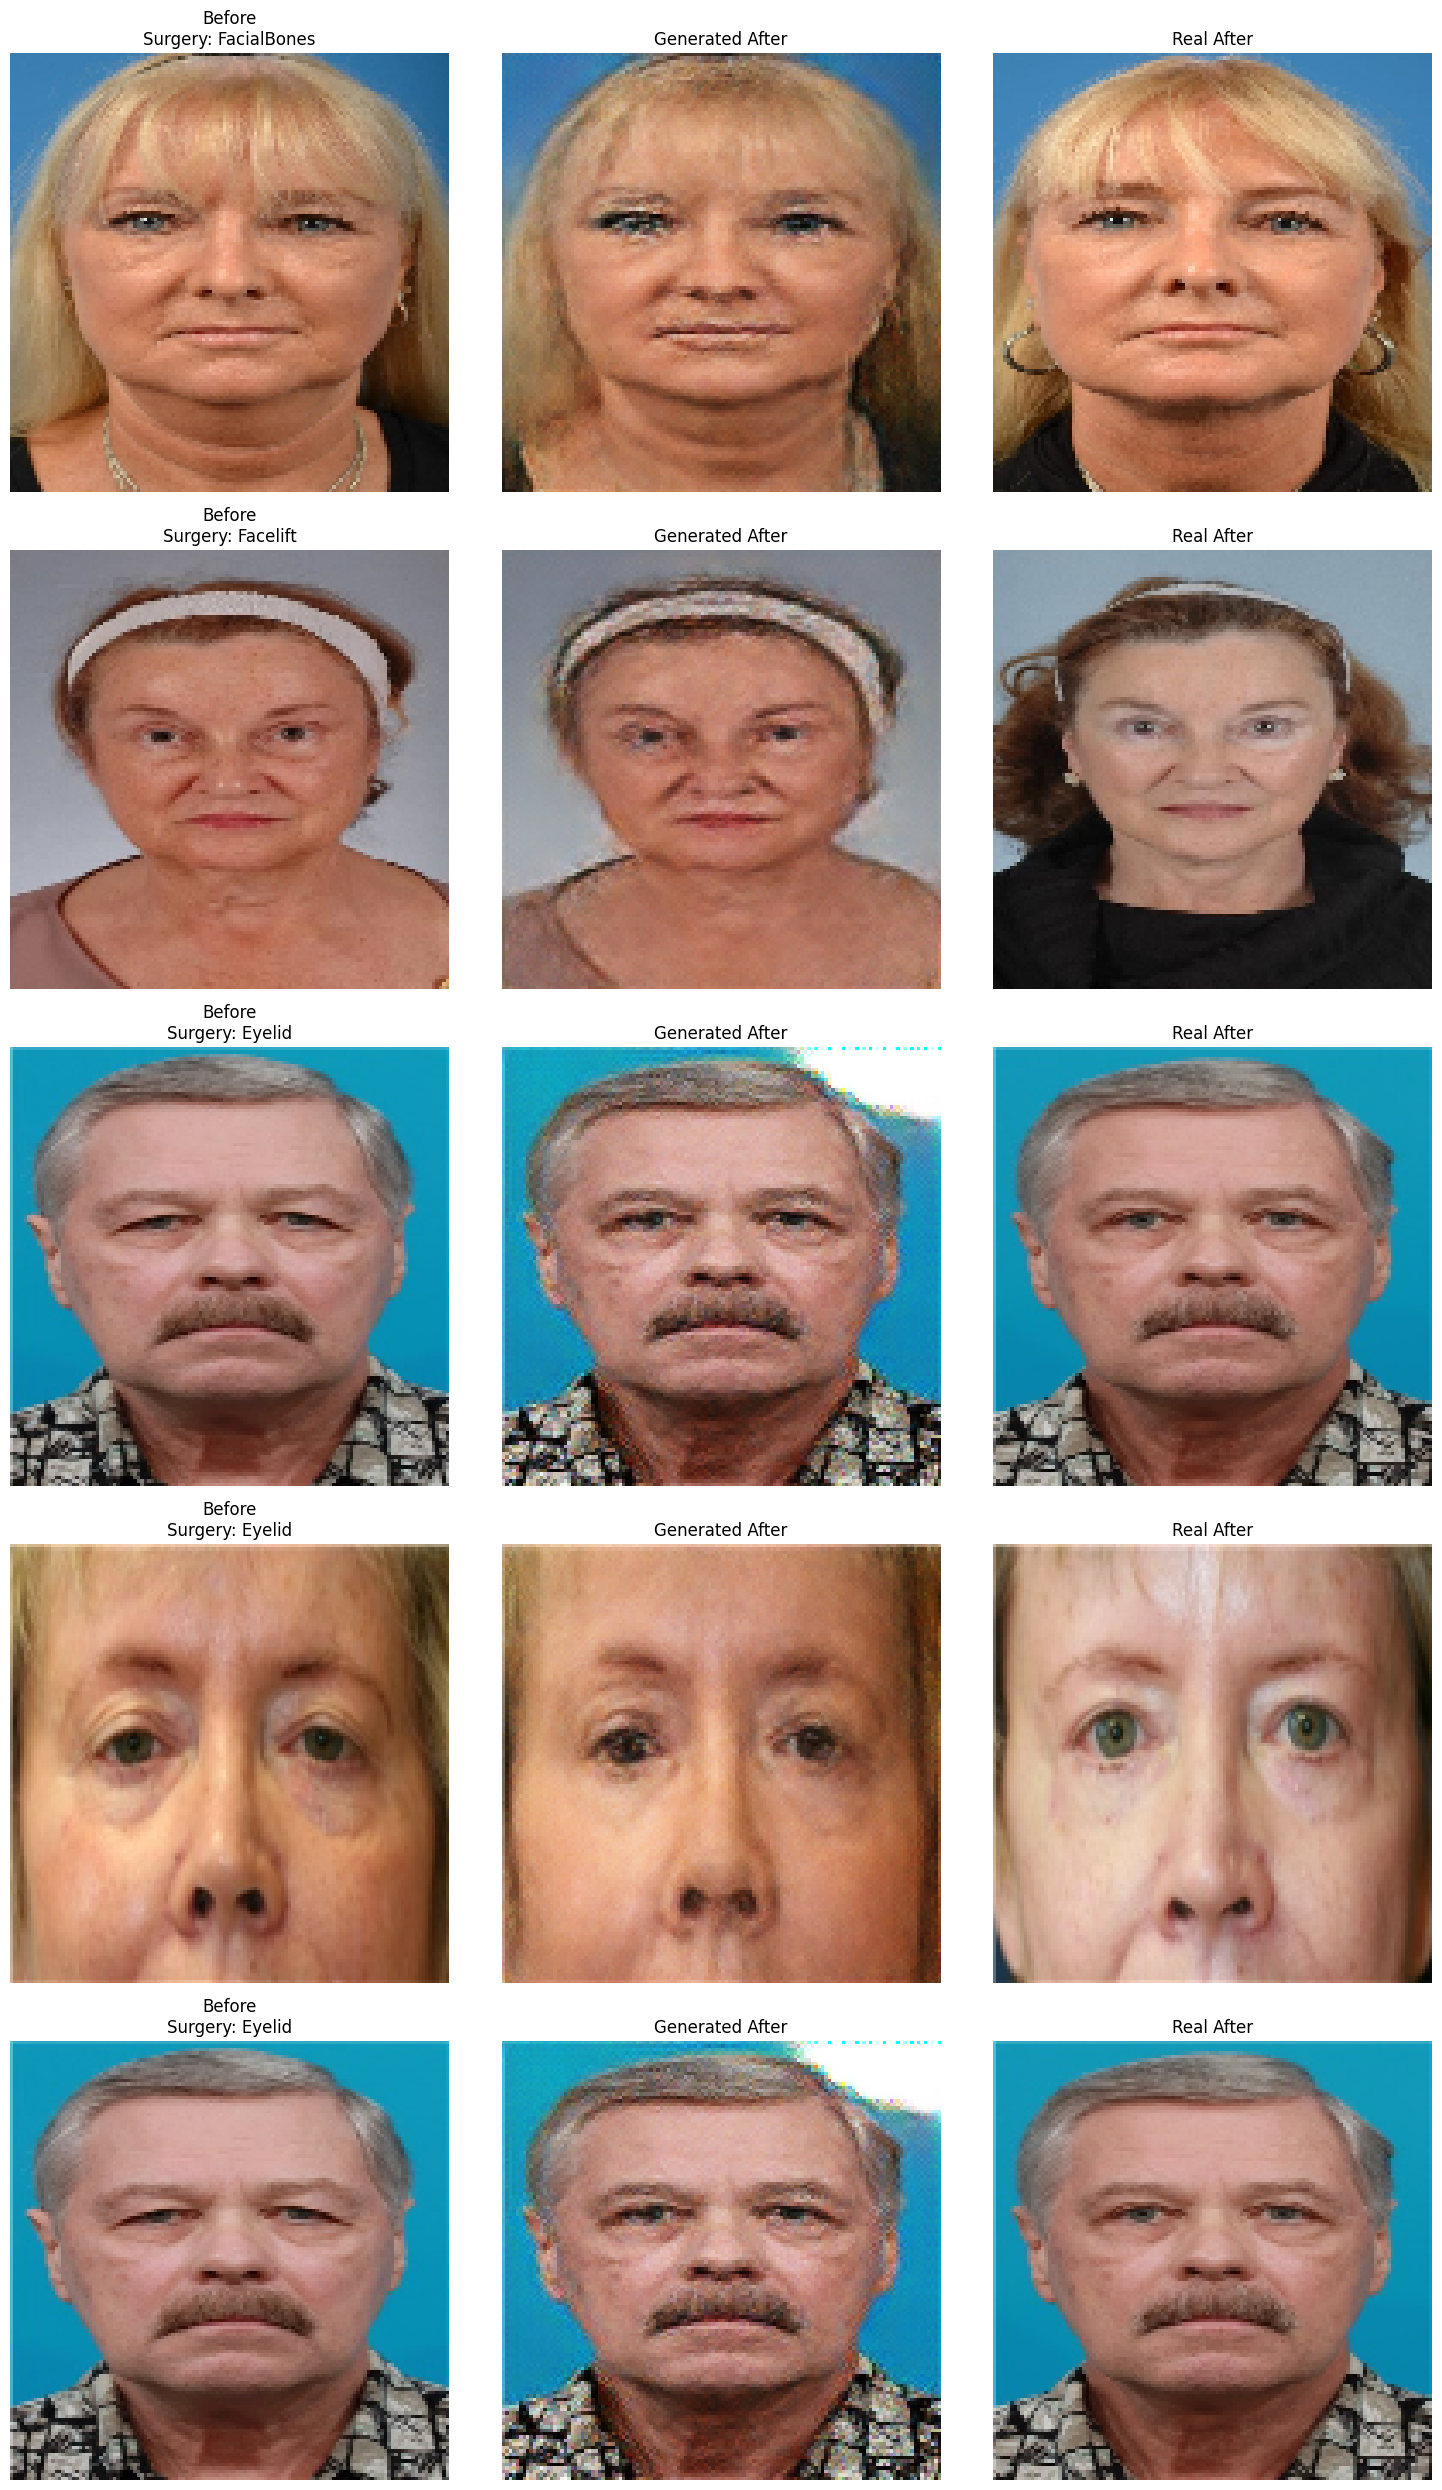

In [ ]:
import matplotlib.pyplot as plt

def visualize_generated_images(before, fake_after, real_after, labels, surgery_types, num_samples=5):
    """
    Visualizes the before, generated after, and real after images side-by-side.

    Parameters:
    - before: Numpy array of "before" images (normalized).
    - fake_after: Numpy array of generated "after" images (normalized).
    - real_after: Numpy array of real "after" images.
    - labels: Numpy array of integer-encoded surgery type labels.
    - surgery_types: List of surgery type names.
    - num_samples: Number of samples to visualize.
    """
    num_cols = 3  # Before, Generated After, Real After
    fig, axes = plt.subplots(num_samples, num_cols, figsize=(15, 5 * num_samples))

    for i in range(num_samples):
        # Before Image
        ax = axes[i, 0]
        img_before = (before[i] + 1.0) / 2.0  # Rescale to [0,1]
        ax.imshow(img_before)
        ax.set_title(f"Before\nSurgery: {surgery_types[labels[i]]}")
        ax.axis('off')

        # Generated After Image
        ax = axes[i, 1]
        ax.imshow(fake_after[i])
        ax.set_title("Generated After")
        ax.axis('off')

        # Real After Image
        ax = axes[i, 2]
        ax.imshow(real_after[i])
        ax.set_title("Real After")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Call the visualization function
visualize_generated_images(
    before=selected_before,
    fake_after=fake_after_rescaled,
    real_after=selected_after_real,
    labels=selected_labels.flatten(),
    surgery_types=surgery_types,
    num_samples=num_examples
)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


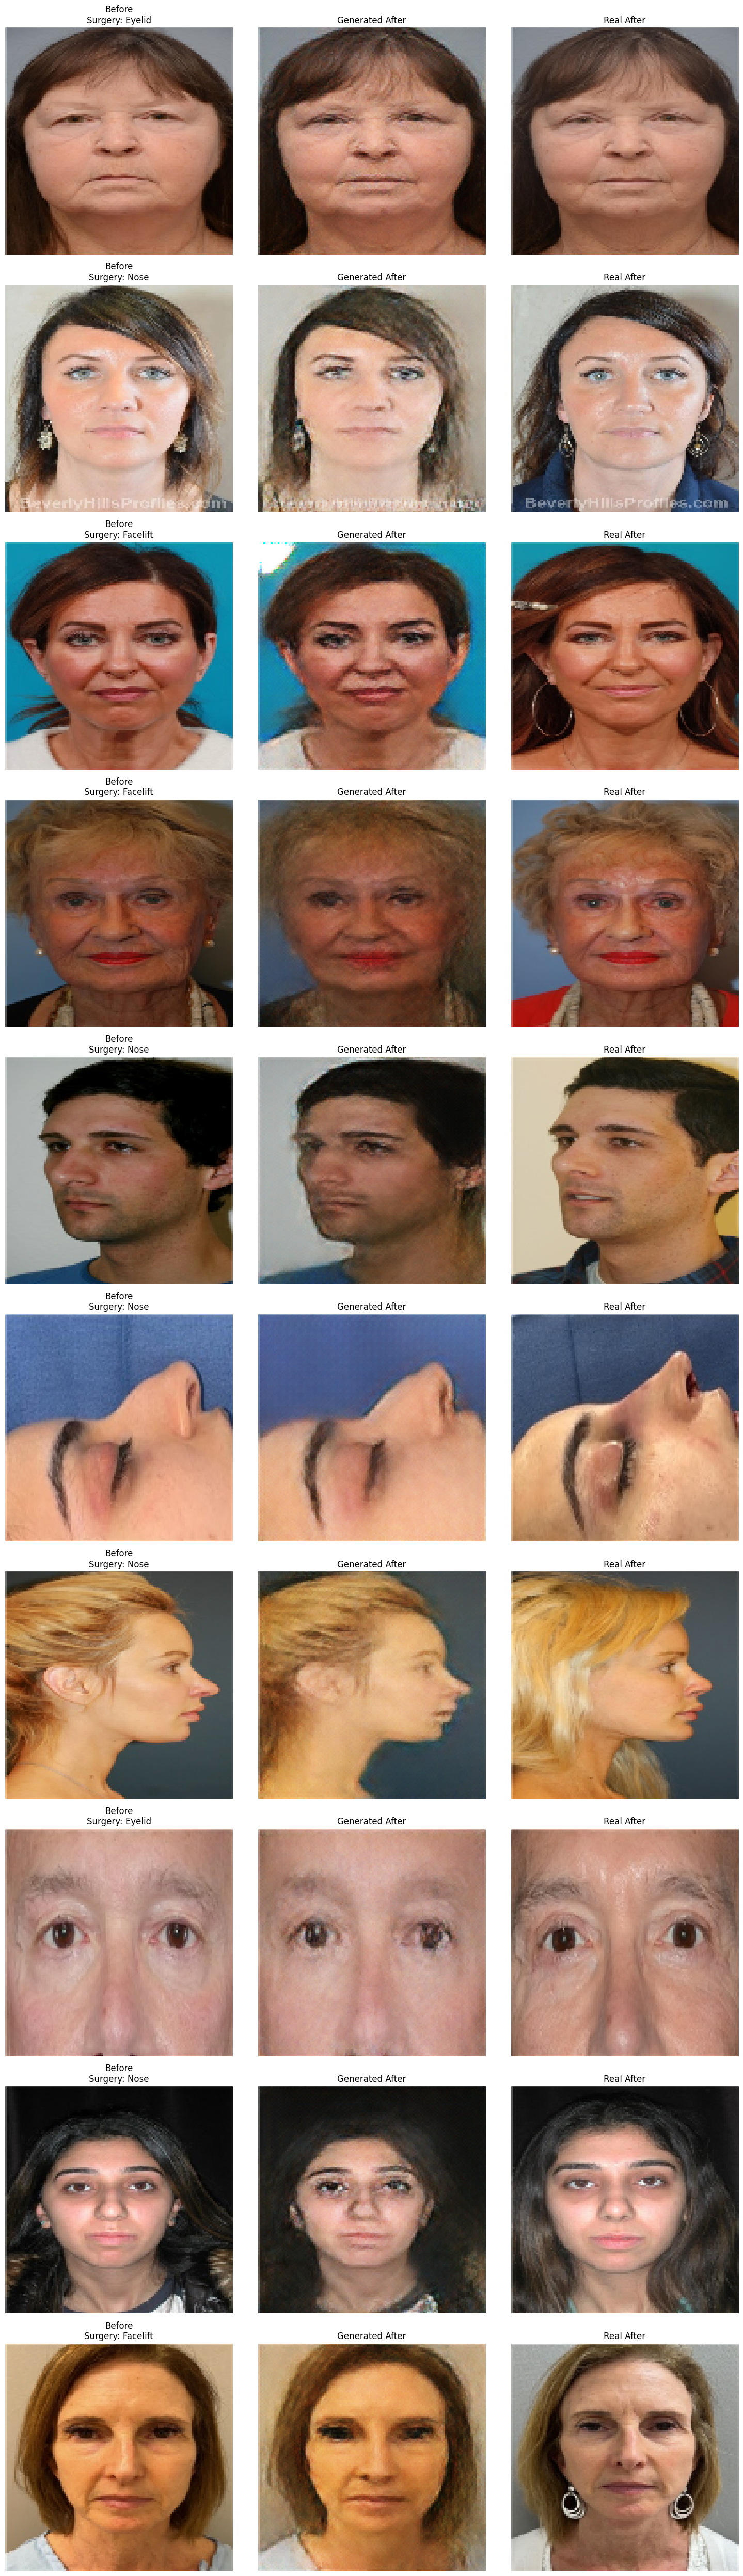

In [ ]:
num_examples = 10  # For example, visualize 10 samples

# Repeat the selection and visualization steps
indices = np.random.choice(len(X_test_before_norm), size=num_examples, replace=False)
selected_before = X_test_before_norm[indices]
selected_after_real = X_test_after[indices]
selected_labels = y_test[indices].reshape(-1, 1)

fake_after = conditional_generator.predict([selected_before, selected_labels])
fake_after_rescaled = (fake_after + 1.0) / 2.0

visualize_generated_images(
    before=selected_before,
    fake_after=fake_after_rescaled,
    real_after=selected_after_real,
    labels=selected_labels.flatten(),
    surgery_types=surgery_types,
    num_samples=num_examples
)


##Hyperparameter Tuning

In [ ]:
!pip install -U keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.6 MB/s eta 0:00:00


In [ ]:
class ConditionalGANHyperModel(kt.HyperModel):
    def __init__(self, img_shape, num_types, perceptual_model):
        self.img_shape = img_shape
        self.num_types = num_types
        self.perceptual_model = perceptual_model

    def build(self, hp):
        # Define hyperparameters to tune
        gen_lr = hp.Float('gen_lr', 1e-5, 5e-4, sampling='log')
        disc_lr = hp.Float('disc_lr', 1e-5, 5e-4, sampling='log')
        lambda_cycle = hp.Float('lambda_cycle', 5.0, 15.0, step=5.0)
        lambda_identity = hp.Float('lambda_identity', 2.0, 10.0, step=2.0)
        lambda_perceptual = hp.Float('lambda_perceptual', 1.0, 5.0, step=1.0)

        # Build Generator and Discriminator
        generator = build_enhanced_generator_conditional(self.img_shape, self.num_types)
        discriminator = build_discriminator_conditional(self.img_shape, self.num_types)

        # Instantiate the GAN with current hyperparameters
        gan = ConditionalGAN(
            generator,
            discriminator,
            self.perceptual_model,
            lambda_cycle=lambda_cycle,
            lambda_identity=lambda_identity,
            lambda_perceptual=lambda_perceptual
        )

        # Compile the GAN with current hyperparameters
        gen_optimizer = Adam(learning_rate=gen_lr, beta_1=0.5)
        disc_optimizer = Adam(learning_rate=disc_lr, beta_1=0.5)
        gan.compile(gen_optimizer=gen_optimizer, disc_optimizer=disc_optimizer)

        return gan


In [ ]:
# Define surgery types and image shape (ensure these are defined as per your dataset)
surgery_types = ['Eyebrow', 'Eyelid', 'Facelift', 'FacialBones', 'Nose']
num_types = len(surgery_types)  # This should be 5
img_height, img_width = 128, 128
img_shape = (img_height, img_width, 3)

# Assume perceptual_model is defined as per your earlier setup
# For example:
# from tensorflow.keras.applications import VGG16
# perceptual_model = ... (define your perceptual model)

# Initialize the HyperModel
hypermodel = ConditionalGANHyperModel(img_shape, num_types, perceptual_model)

# Initialize the Random Search tuner with explicit optimization direction
tuner = kt.RandomSearch(
    hypermodel,
    objective=kt.Objective("total_gen_loss", direction="min"),  # Specify direction explicitly
    max_trials=10,  # Number of hyperparameter combinations to try
    executions_per_trial=1,  # Number of models to build and fit for each trial
    directory='gan_tuning',
    project_name='conditional_gan_hyperparameter_tuning'
)


In [ ]:
class GANHypermodelMonitor(tf.keras.callbacks.Callback):
    def __init__(self, generator, surgery_types, num_examples=5, output_dir='gan_tuning/generated_images'):
        super(GANHypermodelMonitor, self).__init__()
        self.generator = generator
        self.num_examples = num_examples
        self.surgery_types = surgery_types
        self.output_dir = output_dir
        os.makedirs(self.output_dir, exist_ok=True)

        # Select random samples from the test set
        self.indices = np.random.choice(len(X_test_before_norm), size=self.num_examples, replace=False)
        self.seed_before = tf.convert_to_tensor(X_test_before_norm[self.indices] * 2.0 - 1.0, dtype=tf.float32)  # Normalize
        self.seed_labels = y_test[self.indices].reshape(-1, 1)
        self.seed_after = X_test_after[self.indices]

    def on_epoch_end(self, epoch, logs=None):
        # Generate fake after images
        fake_after = self.generator.predict([self.seed_before, self.seed_labels], verbose=0)
        fake_after_rescaled = (fake_after + 1.0) / 2.0  # Rescale to [0,1]
        seed_before_rescaled = (self.seed_before.numpy() + 1.0) / 2.0  # Rescale to [0,1]

        # Plot and save images
        fig, axs = plt.subplots(self.num_examples, 3, figsize=(15, 5 * self.num_examples))
        for i in range(self.num_examples):
            # Before Image
            axs[i, 0].imshow(seed_before_rescaled[i])
            axs[i, 0].set_title(f"Before - {self.surgery_types[y_test[self.indices[i]]]}")  # Label
            axs[i, 0].axis('off')

            # Generated After Image
            axs[i, 1].imshow(fake_after_rescaled[i])
            axs[i, 1].set_title("Generated After")
            axs[i, 1].axis('off')

            # Real After Image
            axs[i, 2].imshow(self.seed_after[i])
            axs[i, 2].set_title("Real After")
            axs[i, 2].axis('off')

        plt.tight_layout()
        plt.savefig(os.path.join(self.output_dir, f"epoch_{epoch+1}.png"))
        plt.close()

        print(f"Saved generated images for epoch {epoch+1} at {self.output_dir}/epoch_{epoch+1}.png")


In [ ]:
# Initialize the tuner without the monitoring callback for simplicity
tuner = kt.RandomSearch(
    hypermodel,
    objective=kt.Objective("total_gen_loss", direction="min"),  # Specify direction explicitly
    max_trials=10,  # Number of hyperparameter combinations to try
    executions_per_trial=1,  # Number of models to build and fit for each trial
    directory='gan_tuning',
    project_name='conditional_gan_hyperparameter_tuning'
)

# Start the hyperparameter search with reduced epochs and without the monitor callback
tuner.search(
    train_dataset_conditional,
    epochs=10,  # Fewer epochs for tuning
    callbacks=[],  # No callbacks during tuning
    verbose=1
)


Trial 10 Complete [00h 03m 48s]
total_gen_loss: 406.15643310546875

Best total_gen_loss So Far: 193.73655700683594
Total elapsed time: 00h 38m 16s


In [ ]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Best Generator Learning Rate: {best_hps.get('gen_lr')}
Best Discriminator Learning Rate: {best_hps.get('disc_lr')}
Best Lambda Cycle: {best_hps.get('lambda_cycle')}
Best Lambda Identity: {best_hps.get('lambda_identity')}
Best Lambda Perceptual: {best_hps.get('lambda_perceptual')}
""")



Best Generator Learning Rate: 1.652778565304619e-05
Best Discriminator Learning Rate: 2.6336875105924428e-05
Best Lambda Cycle: 15.0
Best Lambda Identity: 2.0
Best Lambda Perceptual: 1.0



In [ ]:
# Build the best GAN model
best_gan = tuner.hypermodel.build(best_hps)

# Define callbacks for final training
final_monitor = GANHypermodelMonitor(
    generator=best_gan.generator,
    surgery_types=surgery_types,
    num_examples=5,
    output_dir='gan_tuning/best_model_generated_images'
)

final_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join('gan_tuning', 'best_gan_model.weights.h5'),
    save_weights_only=True,
    save_best_only=True,
    monitor='total_gen_loss',
    mode='min'
)

# Start training the final model
EPOCHS = 100  # Adjust as needed for thorough training

best_gan.fit(
    train_dataset_conditional,
    epochs=EPOCHS,
    callbacks=[final_monitor, final_checkpoint],
    verbose=1
)


Epoch 1/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - cycle_loss: 0.6977 - disc_loss: 0.1171 - gen_gan_loss: 3.6732 - identity_loss: 0.6857 - perceptual_loss: 300.8459 - total_gen_loss: 316.3564

Saved generated images for epoch 1 at gan_tuning/best_model_generated_images/epoch_1.png
73/73 ━━━━━━━━━━━━━━━━━━━━ 40s 314ms/step - cycle_loss: 0.6974 - disc_loss: 0.1158 - gen_gan_loss: 3.6915 - identity_loss: 0.6858 - perceptual_loss: 300.1616 - total_gen_loss: 315.6856
Epoch 2/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - cycle_loss: 0.6239 - disc_loss: 0.0125 - gen_gan_loss: 5.9199 - identity_loss: 0.6910 - perceptual_loss: 229.6552 - total_gen_loss: 246.3154

Saved generated images for epoch 2 at gan_tuning/best_model_generated_images/epoch_2.png
73/73 ━━━━━━━━━━━━━━━━━━━━ 23s 311ms/step - cycle_loss: 0.6232 - disc_loss: 0.0125 - gen_gan_loss: 5.9250 - identity_loss: 0.6907 - perceptual_loss: 229.5019 - total_gen_loss: 246.1562
Epoch 3/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - cycle_loss: 0.5321 - disc_loss: 0.0075 - gen_gan_loss: 6.4105 - identity_loss: 0.6577 - perceptual_loss: 210.7625 - total_gen_loss: 226.4693

Saved generated images for epoch 3 at gan_tuning/best_model_generated_images/epoch_3.png
73/73 ━━━━━━━━━━━━━━━━━━━━ 23s 309ms/step - cycle_loss: 0.5316 - disc_loss: 0.0074 - gen_gan_loss: 6.4088 - identity_loss: 0.6573 - perceptual_loss: 210.8094 - total_gen_loss: 226.5062
Epoch 4/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - cycle_loss: 0.4668 - disc_loss: 0.0071 - gen_gan_loss: 6.3227 - identity_loss: 0.6039 - perceptual_loss: 202.3651 - total_gen_loss: 216.8975

Saved generated images for epoch 4 at gan_tuning/best_model_generated_images/epoch_4.png
73/73 ━━━━━━━━━━━━━━━━━━━━ 23s 312ms/step - cycle_loss: 0.4665 - disc_loss: 0.0071 - gen_gan_loss: 6.3279 - identity_loss: 0.6033 - perceptual_loss: 202.2901 - total_gen_loss: 216.8221
Epoch 5/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - cycle_loss: 0.4199 - disc_loss: 0.0058 - gen_gan_loss: 6.5647 - identity_loss: 0.5551 - perceptual_loss: 197.7555 - total_gen_loss: 211.7293

Saved generated images for epoch 5 at gan_tuning/best_model_generated_images/epoch_5.png
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 308ms/step - cycle_loss: 0.4196 - disc_loss: 0.0058 - gen_gan_loss: 6.5684 - identity_loss: 0.5549 - perceptual_loss: 197.6949 - total_gen_loss: 211.6678
Epoch 6/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - cycle_loss: 0.3822 - disc_loss: 0.0057 - gen_gan_loss: 6.6522 - identity_loss: 0.5109 - perceptual_loss: 194.3896 - total_gen_loss: 207.7960

Saved generated images for epoch 6 at gan_tuning/best_model_generated_images/epoch_6.png
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 309ms/step - cycle_loss: 0.3819 - disc_loss: 0.0057 - gen_gan_loss: 6.6486 - identity_loss: 0.5103 - perceptual_loss: 194.3358 - total_gen_loss: 207.7335
Epoch 7/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - cycle_loss: 0.3516 - disc_loss: 0.0057 - gen_gan_loss: 6.6087 - identity_loss: 0.4690 - perceptual_loss: 192.2698 - total_gen_loss: 205.0899

Saved generated images for epoch 7 at gan_tuning/best_model_generated_images/epoch_7.png
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 305ms/step - cycle_loss: 0.3515 - disc_loss: 0.0056 - gen_gan_loss: 6.6158 - identity_loss: 0.4686 - perceptual_loss: 192.3123 - total_gen_loss: 205.1377
Epoch 8/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - cycle_loss: 0.3234 - disc_loss: 0.0050 - gen_gan_loss: 6.8977 - identity_loss: 0.4368 - perceptual_loss: 190.7481 - total_gen_loss: 203.3696

Saved generated images for epoch 8 at gan_tuning/best_model_generated_images/epoch_8.png
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 308ms/step - cycle_loss: 0.3232 - disc_loss: 0.0050 - gen_gan_loss: 6.8992 - identity_loss: 0.4368 - perceptual_loss: 190.6248 - total_gen_loss: 203.2460
Epoch 9/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - cycle_loss: 0.3078 - disc_loss: 0.0064 - gen_gan_loss: 6.6074 - identity_loss: 0.4113 - perceptual_loss: 189.7614 - total_gen_loss: 201.8088

Saved generated images for epoch 9 at gan_tuning/best_model_generated_images/epoch_9.png
73/73 ━━━━━━━━━━━━━━━━━━━━ 23s 311ms/step - cycle_loss: 0.3078 - disc_loss: 0.0063 - gen_gan_loss: 6.6150 - identity_loss: 0.4111 - perceptual_loss: 189.7062 - total_gen_loss: 201.7599
Epoch 10/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - cycle_loss: 0.2942 - disc_loss: 0.0036 - gen_gan_loss: 7.0607 - identity_loss: 0.3979 - perceptual_loss: 188.2978 - total_gen_loss: 200.5673

Saved generated images for epoch 10 at gan_tuning/best_model_generated_images/epoch_10.png
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 306ms/step - cycle_loss: 0.2940 - disc_loss: 0.0037 - gen_gan_loss: 7.0511 - identity_loss: 0.3977 - perceptual_loss: 188.3424 - total_gen_loss: 200.5993
Epoch 11/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - cycle_loss: 0.2807 - disc_loss: 0.0033 - gen_gan_loss: 7.1624 - identity_loss: 0.3873 - perceptual_loss: 187.2417 - total_gen_loss: 199.3898

Saved generated images for epoch 11 at gan_tuning/best_model_generated_images/epoch_11.png
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 308ms/step - cycle_loss: 0.2806 - disc_loss: 0.0033 - gen_gan_loss: 7.1607 - identity_loss: 0.3874 - perceptual_loss: 187.1748 - total_gen_loss: 199.3191
Epoch 12/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - cycle_loss: 0.2721 - disc_loss: 0.0035 - gen_gan_loss: 6.8724 - identity_loss: 0.3772 - perceptual_loss: 186.6219 - total_gen_loss: 198.3303

Saved generated images for epoch 12 at gan_tuning/best_model_generated_images/epoch_12.png
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 308ms/step - cycle_loss: 0.2722 - disc_loss: 0.0035 - gen_gan_loss: 6.8779 - identity_loss: 0.3769 - perceptual_loss: 186.5083 - total_gen_loss: 198.2234
Epoch 13/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - cycle_loss: 0.2687 - disc_loss: 0.0039 - gen_gan_loss: 6.9978 - identity_loss: 0.3668 - perceptual_loss: 185.8284 - total_gen_loss: 197.5898

Saved generated images for epoch 13 at gan_tuning/best_model_generated_images/epoch_13.png
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 305ms/step - cycle_loss: 0.2686 - disc_loss: 0.0039 - gen_gan_loss: 7.0085 - identity_loss: 0.3665 - perceptual_loss: 185.7688 - total_gen_loss: 197.5398
Epoch 14/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - cycle_loss: 0.2691 - disc_loss: 0.0029 - gen_gan_loss: 7.1257 - identity_loss: 0.3672 - perceptual_loss: 185.3841 - total_gen_loss: 197.2813

Saved generated images for epoch 14 at gan_tuning/best_model_generated_images/epoch_14.png
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 308ms/step - cycle_loss: 0.2691 - disc_loss: 0.0029 - gen_gan_loss: 7.1187 - identity_loss: 0.3672 - perceptual_loss: 185.2695 - total_gen_loss: 197.1585
Epoch 15/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - cycle_loss: 0.2653 - disc_loss: 0.0026 - gen_gan_loss: 7.2513 - identity_loss: 0.3614 - perceptual_loss: 184.8719 - total_gen_loss: 196.8255

Saved generated images for epoch 15 at gan_tuning/best_model_generated_images/epoch_15.png
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 305ms/step - cycle_loss: 0.2651 - disc_loss: 0.0026 - gen_gan_loss: 7.2417 - identity_loss: 0.3612 - perceptual_loss: 184.8187 - total_gen_loss: 196.7589
Epoch 16/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - cycle_loss: 0.2517 - disc_loss: 0.0022 - gen_gan_loss: 7.7035 - identity_loss: 0.3530 - perceptual_loss: 183.9794 - total_gen_loss: 196.1644

Saved generated images for epoch 16 at gan_tuning/best_model_generated_images/epoch_16.png
73/73 ━━━━━━━━━━━━━━━━━━━━ 23s 313ms/step - cycle_loss: 0.2515 - disc_loss: 0.0021 - gen_gan_loss: 7.7020 - identity_loss: 0.3528 - perceptual_loss: 183.8954 - total_gen_loss: 196.0749
Epoch 17/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - cycle_loss: 0.2389 - disc_loss: 0.0016 - gen_gan_loss: 7.8258 - identity_loss: 0.3442 - perceptual_loss: 183.0998 - total_gen_loss: 195.1982

Saved generated images for epoch 17 at gan_tuning/best_model_generated_images/epoch_17.png
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 305ms/step - cycle_loss: 0.2390 - disc_loss: 0.0016 - gen_gan_loss: 7.8153 - identity_loss: 0.3441 - perceptual_loss: 183.0905 - total_gen_loss: 195.1783
Epoch 18/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - cycle_loss: 0.2323 - disc_loss: 0.0024 - gen_gan_loss: 7.8598 - identity_loss: 0.3358 - perceptual_loss: 183.0046 - total_gen_loss: 195.0208

Saved generated images for epoch 18 at gan_tuning/best_model_generated_images/epoch_18.png
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 305ms/step - cycle_loss: 0.2324 - disc_loss: 0.0024 - gen_gan_loss: 7.8779 - identity_loss: 0.3355 - perceptual_loss: 182.9749 - total_gen_loss: 195.0091
Epoch 19/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - cycle_loss: 0.2305 - disc_loss: 0.0022 - gen_gan_loss: 8.0460 - identity_loss: 0.3205 - perceptual_loss: 183.0577 - total_gen_loss: 195.2014

Saved generated images for epoch 19 at gan_tuning/best_model_generated_images/epoch_19.png
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 305ms/step - cycle_loss: 0.2307 - disc_loss: 0.0022 - gen_gan_loss: 8.0483 - identity_loss: 0.3205 - perceptual_loss: 183.1911 - total_gen_loss: 195.3409
Epoch 20/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - cycle_loss: 0.2263 - disc_loss: 0.0021 - gen_gan_loss: 7.4633 - identity_loss: 0.3055 - perceptual_loss: 182.4037 - total_gen_loss: 193.8725

Saved generated images for epoch 20 at gan_tuning/best_model_generated_images/epoch_20.png
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 305ms/step - cycle_loss: 0.2263 - disc_loss: 0.0021 - gen_gan_loss: 7.4641 - identity_loss: 0.3056 - perceptual_loss: 182.4053 - total_gen_loss: 193.8749
Epoch 21/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - cycle_loss: 0.2247 - disc_loss: 0.0024 - gen_gan_loss: 7.5939 - identity_loss: 0.2988 - perceptual_loss: 181.9308 - total_gen_loss: 193.4921

Saved generated images for epoch 21 at gan_tuning/best_model_generated_images/epoch_21.png
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 305ms/step - cycle_loss: 0.2246 - disc_loss: 0.0023 - gen_gan_loss: 7.5906 - identity_loss: 0.2988 - perceptual_loss: 181.9604 - total_gen_loss: 193.5170
Epoch 22/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - cycle_loss: 0.2222 - disc_loss: 0.0024 - gen_gan_loss: 7.8760 - identity_loss: 0.2945 - perceptual_loss: 182.2359 - total_gen_loss: 194.0336

Saved generated images for epoch 22 at gan_tuning/best_model_generated_images/epoch_22.png
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 306ms/step - cycle_loss: 0.2221 - disc_loss: 0.0024 - gen_gan_loss: 7.8766 - identity_loss: 0.2944 - perceptual_loss: 182.2654 - total_gen_loss: 194.0629
Epoch 23/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - cycle_loss: 0.2311 - disc_loss: 0.0041 - gen_gan_loss: 7.0147 - identity_loss: 0.2802 - perceptual_loss: 182.6198 - total_gen_loss: 193.6609

Saved generated images for epoch 23 at gan_tuning/best_model_generated_images/epoch_23.png
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 306ms/step - cycle_loss: 0.2311 - disc_loss: 0.0041 - gen_gan_loss: 7.0343 - identity_loss: 0.2802 - perceptual_loss: 182.5893 - total_gen_loss: 193.6502
Epoch 24/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - cycle_loss: 0.2283 - disc_loss: 0.0045 - gen_gan_loss: 7.6852 - identity_loss: 0.2592 - perceptual_loss: 182.4363 - total_gen_loss: 194.0641

Saved generated images for epoch 24 at gan_tuning/best_model_generated_images/epoch_24.png
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 305ms/step - cycle_loss: 0.2282 - disc_loss: 0.0045 - gen_gan_loss: 7.6892 - identity_loss: 0.2590 - perceptual_loss: 182.5190 - total_gen_loss: 194.1500
Epoch 25/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - cycle_loss: 0.2125 - disc_loss: 0.0056 - gen_gan_loss: 7.6927 - identity_loss: 0.2356 - perceptual_loss: 182.6503 - total_gen_loss: 194.0011

Saved generated images for epoch 25 at gan_tuning/best_model_generated_images/epoch_25.png
73/73 ━━━━━━━━━━━━━━━━━━━━ 23s 314ms/step - cycle_loss: 0.2123 - disc_loss: 0.0056 - gen_gan_loss: 7.6859 - identity_loss: 0.2352 - perceptual_loss: 182.6497 - total_gen_loss: 193.9907
Epoch 26/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - cycle_loss: 0.2024 - disc_loss: 0.0085 - gen_gan_loss: 7.4480 - identity_loss: 0.2003 - perceptual_loss: 185.0133 - total_gen_loss: 195.8983

Saved generated images for epoch 26 at gan_tuning/best_model_generated_images/epoch_26.png
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 305ms/step - cycle_loss: 0.2023 - disc_loss: 0.0090 - gen_gan_loss: 7.3987 - identity_loss: 0.2000 - perceptual_loss: 185.0771 - total_gen_loss: 195.9108
Epoch 27/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - cycle_loss: 0.1880 - disc_loss: 0.0104 - gen_gan_loss: 7.4047 - identity_loss: 0.1750 - perceptual_loss: 184.6708 - total_gen_loss: 195.2460

Saved generated images for epoch 27 at gan_tuning/best_model_generated_images/epoch_27.png
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 306ms/step - cycle_loss: 0.1880 - disc_loss: 0.0104 - gen_gan_loss: 7.3980 - identity_loss: 0.1748 - perceptual_loss: 184.7753 - total_gen_loss: 195.3434
Epoch 28/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - cycle_loss: 0.1748 - disc_loss: 0.0376 - gen_gan_loss: 6.6102 - identity_loss: 0.1557 - perceptual_loss: 186.2504 - total_gen_loss: 195.7946

Saved generated images for epoch 28 at gan_tuning/best_model_generated_images/epoch_28.png
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 306ms/step - cycle_loss: 0.1747 - disc_loss: 0.0373 - gen_gan_loss: 6.6101 - identity_loss: 0.1555 - perceptual_loss: 186.2734 - total_gen_loss: 195.8154
Epoch 29/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - cycle_loss: 0.1592 - disc_loss: 0.0245 - gen_gan_loss: 5.9497 - identity_loss: 0.1374 - perceptual_loss: 185.7113 - total_gen_loss: 194.3244

Saved generated images for epoch 29 at gan_tuning/best_model_generated_images/epoch_29.png
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 306ms/step - cycle_loss: 0.1591 - disc_loss: 0.0243 - gen_gan_loss: 5.9556 - identity_loss: 0.1374 - perceptual_loss: 185.7465 - total_gen_loss: 194.3630
Epoch 30/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - cycle_loss: 0.1543 - disc_loss: 0.0208 - gen_gan_loss: 6.1208 - identity_loss: 0.1315 - perceptual_loss: 186.2673 - total_gen_loss: 194.9650

Saved generated images for epoch 30 at gan_tuning/best_model_generated_images/epoch_30.png
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 305ms/step - cycle_loss: 0.1541 - disc_loss: 0.0207 - gen_gan_loss: 6.1125 - identity_loss: 0.1314 - perceptual_loss: 186.2709 - total_gen_loss: 194.9573
Epoch 31/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - cycle_loss: 0.1504 - disc_loss: 0.0326 - gen_gan_loss: 5.7906 - identity_loss: 0.1265 - perceptual_loss: 185.1877 - total_gen_loss: 193.4871

Saved generated images for epoch 31 at gan_tuning/best_model_generated_images/epoch_31.png
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 308ms/step - cycle_loss: 0.1505 - disc_loss: 0.0325 - gen_gan_loss: 5.7807 - identity_loss: 0.1265 - perceptual_loss: 185.0801 - total_gen_loss: 193.3710
Epoch 32/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - cycle_loss: 0.1482 - disc_loss: 0.0354 - gen_gan_loss: 5.7140 - identity_loss: 0.1236 - perceptual_loss: 184.0691 - total_gen_loss: 192.2529

Saved generated images for epoch 32 at gan_tuning/best_model_generated_images/epoch_32.png
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 308ms/step - cycle_loss: 0.1480 - disc_loss: 0.0354 - gen_gan_loss: 5.7171 - identity_loss: 0.1235 - perceptual_loss: 183.9258 - total_gen_loss: 192.1101
Epoch 33/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - cycle_loss: 0.1544 - disc_loss: 0.0359 - gen_gan_loss: 5.4642 - identity_loss: 0.1256 - perceptual_loss: 183.2550 - total_gen_loss: 191.2866

Saved generated images for epoch 33 at gan_tuning/best_model_generated_images/epoch_33.png
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 306ms/step - cycle_loss: 0.1546 - disc_loss: 0.0363 - gen_gan_loss: 5.4728 - identity_loss: 0.1257 - perceptual_loss: 183.2931 - total_gen_loss: 191.3365
Epoch 34/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - cycle_loss: 0.1797 - disc_loss: 0.0516 - gen_gan_loss: 5.1222 - identity_loss: 0.1339 - perceptual_loss: 183.0033 - total_gen_loss: 191.0881

Saved generated images for epoch 34 at gan_tuning/best_model_generated_images/epoch_34.png
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 306ms/step - cycle_loss: 0.1796 - disc_loss: 0.0515 - gen_gan_loss: 5.1404 - identity_loss: 0.1338 - perceptual_loss: 182.9706 - total_gen_loss: 191.0722
Epoch 35/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - cycle_loss: 0.1796 - disc_loss: 0.0334 - gen_gan_loss: 5.0521 - identity_loss: 0.1361 - perceptual_loss: 182.1556 - total_gen_loss: 190.1744

Saved generated images for epoch 35 at gan_tuning/best_model_generated_images/epoch_35.png
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 306ms/step - cycle_loss: 0.1796 - disc_loss: 0.0337 - gen_gan_loss: 5.0860 - identity_loss: 0.1361 - perceptual_loss: 182.1698 - total_gen_loss: 190.2216
Epoch 36/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - cycle_loss: 0.1754 - disc_loss: 0.0437 - gen_gan_loss: 5.1079 - identity_loss: 0.1339 - perceptual_loss: 181.5847 - total_gen_loss: 189.5908

Saved generated images for epoch 36 at gan_tuning/best_model_generated_images/epoch_36.png
73/73 ━━━━━━━━━━━━━━━━━━━━ 23s 316ms/step - cycle_loss: 0.1751 - disc_loss: 0.0440 - gen_gan_loss: 5.0989 - identity_loss: 0.1336 - perceptual_loss: 181.5432 - total_gen_loss: 189.5367
Epoch 37/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - cycle_loss: 0.1734 - disc_loss: 0.0290 - gen_gan_loss: 5.2110 - identity_loss: 0.1328 - perceptual_loss: 182.2276 - total_gen_loss: 190.3057

Saved generated images for epoch 37 at gan_tuning/best_model_generated_images/epoch_37.png
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 306ms/step - cycle_loss: 0.1733 - disc_loss: 0.0288 - gen_gan_loss: 5.2117 - identity_loss: 0.1327 - perceptual_loss: 182.1241 - total_gen_loss: 190.2007
Epoch 38/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - cycle_loss: 0.1697 - disc_loss: 0.0305 - gen_gan_loss: 5.1433 - identity_loss: 0.1309 - perceptual_loss: 181.4565 - total_gen_loss: 189.4067

Saved generated images for epoch 38 at gan_tuning/best_model_generated_images/epoch_38.png
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 306ms/step - cycle_loss: 0.1696 - disc_loss: 0.0303 - gen_gan_loss: 5.1550 - identity_loss: 0.1309 - perceptual_loss: 181.3451 - total_gen_loss: 189.3058
Epoch 39/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - cycle_loss: 0.1688 - disc_loss: 0.0476 - gen_gan_loss: 5.0747 - identity_loss: 0.1290 - perceptual_loss: 180.8458 - total_gen_loss: 188.7098

Saved generated images for epoch 39 at gan_tuning/best_model_generated_images/epoch_39.png
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 308ms/step - cycle_loss: 0.1685 - disc_loss: 0.0473 - gen_gan_loss: 5.0616 - identity_loss: 0.1288 - perceptual_loss: 180.7119 - total_gen_loss: 188.5588
Epoch 40/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - cycle_loss: 0.1683 - disc_loss: 0.0244 - gen_gan_loss: 5.3348 - identity_loss: 0.1301 - perceptual_loss: 180.6201 - total_gen_loss: 188.7401

Saved generated images for epoch 40 at gan_tuning/best_model_generated_images/epoch_40.png
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 305ms/step - cycle_loss: 0.1683 - disc_loss: 0.0248 - gen_gan_loss: 5.3018 - identity_loss: 0.1299 - perceptual_loss: 180.5397 - total_gen_loss: 188.6265
Epoch 41/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - cycle_loss: 0.1695 - disc_loss: 0.0255 - gen_gan_loss: 5.3759 - identity_loss: 0.1280 - perceptual_loss: 180.6145 - total_gen_loss: 188.7893

Saved generated images for epoch 41 at gan_tuning/best_model_generated_images/epoch_41.png
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 305ms/step - cycle_loss: 0.1699 - disc_loss: 0.0252 - gen_gan_loss: 5.3929 - identity_loss: 0.1283 - perceptual_loss: 180.5965 - total_gen_loss: 188.7941
Epoch 42/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - cycle_loss: 0.1668 - disc_loss: 0.0307 - gen_gan_loss: 4.9216 - identity_loss: 0.1269 - perceptual_loss: 180.6628 - total_gen_loss: 188.3402

Saved generated images for epoch 42 at gan_tuning/best_model_generated_images/epoch_42.png
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 305ms/step - cycle_loss: 0.1667 - disc_loss: 0.0305 - gen_gan_loss: 4.9305 - identity_loss: 0.1269 - perceptual_loss: 180.6001 - total_gen_loss: 188.2855
Epoch 43/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - cycle_loss: 0.1669 - disc_loss: 0.0337 - gen_gan_loss: 4.9717 - identity_loss: 0.1287 - perceptual_loss: 180.4466 - total_gen_loss: 188.1791

Saved generated images for epoch 43 at gan_tuning/best_model_generated_images/epoch_43.png
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 305ms/step - cycle_loss: 0.1668 - disc_loss: 0.0354 - gen_gan_loss: 4.9890 - identity_loss: 0.1311 - perceptual_loss: 180.7951 - total_gen_loss: 188.5489
Epoch 44/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - cycle_loss: 0.1637 - disc_loss: 0.0333 - gen_gan_loss: 5.2636 - identity_loss: 0.1253 - perceptual_loss: 179.7061 - total_gen_loss: 187.6760

Saved generated images for epoch 44 at gan_tuning/best_model_generated_images/epoch_44.png
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 305ms/step - cycle_loss: 0.1640 - disc_loss: 0.0332 - gen_gan_loss: 5.2539 - identity_loss: 0.1253 - perceptual_loss: 179.6240 - total_gen_loss: 187.5884
Epoch 45/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - cycle_loss: 0.1613 - disc_loss: 0.0319 - gen_gan_loss: 5.0427 - identity_loss: 0.1232 - perceptual_loss: 179.9276 - total_gen_loss: 187.6370

Saved generated images for epoch 45 at gan_tuning/best_model_generated_images/epoch_45.png
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 305ms/step - cycle_loss: 0.1612 - disc_loss: 0.0319 - gen_gan_loss: 5.0292 - identity_loss: 0.1233 - perceptual_loss: 179.8590 - total_gen_loss: 187.5535
Epoch 46/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - cycle_loss: 0.1599 - disc_loss: 0.0263 - gen_gan_loss: 4.9917 - identity_loss: 0.1239 - perceptual_loss: 179.9310 - total_gen_loss: 187.5692

Saved generated images for epoch 46 at gan_tuning/best_model_generated_images/epoch_46.png
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 306ms/step - cycle_loss: 0.1600 - disc_loss: 0.0264 - gen_gan_loss: 4.9906 - identity_loss: 0.1237 - perceptual_loss: 179.9780 - total_gen_loss: 187.6163
Epoch 47/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - cycle_loss: 0.1564 - disc_loss: 0.0304 - gen_gan_loss: 5.1322 - identity_loss: 0.1205 - perceptual_loss: 179.4426 - total_gen_loss: 187.1623

Saved generated images for epoch 47 at gan_tuning/best_model_generated_images/epoch_47.png
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 305ms/step - cycle_loss: 0.1563 - disc_loss: 0.0302 - gen_gan_loss: 5.1482 - identity_loss: 0.1205 - perceptual_loss: 179.3359 - total_gen_loss: 187.0697
Epoch 48/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - cycle_loss: 0.1548 - disc_loss: 0.0300 - gen_gan_loss: 4.8469 - identity_loss: 0.1206 - perceptual_loss: 179.4857 - total_gen_loss: 186.8954

Saved generated images for epoch 48 at gan_tuning/best_model_generated_images/epoch_48.png
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 305ms/step - cycle_loss: 0.1549 - disc_loss: 0.0302 - gen_gan_loss: 4.8520 - identity_loss: 0.1207 - perceptual_loss: 179.4222 - total_gen_loss: 186.8396
Epoch 49/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - cycle_loss: 0.1537 - disc_loss: 0.0332 - gen_gan_loss: 5.2299 - identity_loss: 0.1205 - perceptual_loss: 179.4003 - total_gen_loss: 187.1769

Saved generated images for epoch 49 at gan_tuning/best_model_generated_images/epoch_49.png
73/73 ━━━━━━━━━━━━━━━━━━━━ 23s 319ms/step - cycle_loss: 0.1537 - disc_loss: 0.0329 - gen_gan_loss: 5.2473 - identity_loss: 0.1205 - perceptual_loss: 179.3764 - total_gen_loss: 187.1703
Epoch 50/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - cycle_loss: 0.1539 - disc_loss: 0.0350 - gen_gan_loss: 5.1118 - identity_loss: 0.1198 - perceptual_loss: 179.3403 - total_gen_loss: 187.0006

Saved generated images for epoch 50 at gan_tuning/best_model_generated_images/epoch_50.png
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 305ms/step - cycle_loss: 0.1539 - disc_loss: 0.0354 - gen_gan_loss: 5.1222 - identity_loss: 0.1198 - perceptual_loss: 179.3711 - total_gen_loss: 187.0413
Epoch 51/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - cycle_loss: 0.1510 - disc_loss: 0.0325 - gen_gan_loss: 5.2474 - identity_loss: 0.1178 - perceptual_loss: 179.7226 - total_gen_loss: 187.4711

Saved generated images for epoch 51 at gan_tuning/best_model_generated_images/epoch_51.png
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 305ms/step - cycle_loss: 0.1510 - disc_loss: 0.0326 - gen_gan_loss: 5.2690 - identity_loss: 0.1178 - perceptual_loss: 180.3748 - total_gen_loss: 188.1448
Epoch 52/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - cycle_loss: 0.1511 - disc_loss: 0.0350 - gen_gan_loss: 5.2050 - identity_loss: 0.1164 - perceptual_loss: 178.8528 - total_gen_loss: 186.5567

Saved generated images for epoch 52 at gan_tuning/best_model_generated_images/epoch_52.png
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 305ms/step - cycle_loss: 0.1509 - disc_loss: 0.0360 - gen_gan_loss: 5.1698 - identity_loss: 0.1163 - perceptual_loss: 178.8729 - total_gen_loss: 186.5392
Epoch 53/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - cycle_loss: 0.1494 - disc_loss: 0.0225 - gen_gan_loss: 5.3506 - identity_loss: 0.1156 - perceptual_loss: 178.7858 - total_gen_loss: 186.6094

Saved generated images for epoch 53 at gan_tuning/best_model_generated_images/epoch_53.png
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 305ms/step - cycle_loss: 0.1495 - disc_loss: 0.0224 - gen_gan_loss: 5.3642 - identity_loss: 0.1156 - perceptual_loss: 178.7109 - total_gen_loss: 186.5487
Epoch 54/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - cycle_loss: 0.1505 - disc_loss: 0.0278 - gen_gan_loss: 5.1168 - identity_loss: 0.1169 - perceptual_loss: 178.9831 - total_gen_loss: 186.5912

Saved generated images for epoch 54 at gan_tuning/best_model_generated_images/epoch_54.png
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 306ms/step - cycle_loss: 0.1503 - disc_loss: 0.0276 - gen_gan_loss: 5.1240 - identity_loss: 0.1169 - perceptual_loss: 178.8618 - total_gen_loss: 186.4742
Epoch 55/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - cycle_loss: 0.1509 - disc_loss: 0.0349 - gen_gan_loss: 5.3448 - identity_loss: 0.1164 - perceptual_loss: 179.1302 - total_gen_loss: 186.9717

Saved generated images for epoch 55 at gan_tuning/best_model_generated_images/epoch_55.png
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 305ms/step - cycle_loss: 0.1510 - disc_loss: 0.0347 - gen_gan_loss: 5.3540 - identity_loss: 0.1164 - perceptual_loss: 179.2432 - total_gen_loss: 187.0952
Epoch 56/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - cycle_loss: 0.1479 - disc_loss: 0.0323 - gen_gan_loss: 5.1462 - identity_loss: 0.1139 - perceptual_loss: 178.4996 - total_gen_loss: 186.0928

Saved generated images for epoch 56 at gan_tuning/best_model_generated_images/epoch_56.png
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 305ms/step - cycle_loss: 0.1478 - disc_loss: 0.0320 - gen_gan_loss: 5.1462 - identity_loss: 0.1138 - perceptual_loss: 178.5658 - total_gen_loss: 186.1570
Epoch 57/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - cycle_loss: 0.1479 - disc_loss: 0.0228 - gen_gan_loss: 5.0630 - identity_loss: 0.1142 - perceptual_loss: 178.6014 - total_gen_loss: 186.1112

Saved generated images for epoch 57 at gan_tuning/best_model_generated_images/epoch_57.png
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 305ms/step - cycle_loss: 0.1484 - disc_loss: 0.0227 - gen_gan_loss: 5.0937 - identity_loss: 0.1146 - perceptual_loss: 178.6665 - total_gen_loss: 186.2155
Epoch 58/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - cycle_loss: 0.1461 - disc_loss: 0.0314 - gen_gan_loss: 5.0773 - identity_loss: 0.1146 - perceptual_loss: 178.3788 - total_gen_loss: 185.8766

Saved generated images for epoch 58 at gan_tuning/best_model_generated_images/epoch_58.png
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 305ms/step - cycle_loss: 0.1462 - disc_loss: 0.0310 - gen_gan_loss: 5.0991 - identity_loss: 0.1149 - perceptual_loss: 178.4014 - total_gen_loss: 185.9239
Epoch 59/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - cycle_loss: 0.1456 - disc_loss: 0.0317 - gen_gan_loss: 5.1225 - identity_loss: 0.1121 - perceptual_loss: 178.1730 - total_gen_loss: 185.7035

Saved generated images for epoch 59 at gan_tuning/best_model_generated_images/epoch_59.png
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 305ms/step - cycle_loss: 0.1455 - disc_loss: 0.0314 - gen_gan_loss: 5.1389 - identity_loss: 0.1121 - perceptual_loss: 178.0974 - total_gen_loss: 185.6429
Epoch 60/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - cycle_loss: 0.1442 - disc_loss: 0.0377 - gen_gan_loss: 5.0353 - identity_loss: 0.1142 - perceptual_loss: 178.2454 - total_gen_loss: 185.6714

Saved generated images for epoch 60 at gan_tuning/best_model_generated_images/epoch_60.png
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 308ms/step - cycle_loss: 0.1442 - disc_loss: 0.0398 - gen_gan_loss: 4.9932 - identity_loss: 0.1141 - perceptual_loss: 178.1524 - total_gen_loss: 185.5361
Epoch 61/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - cycle_loss: 0.1419 - disc_loss: 0.0286 - gen_gan_loss: 5.2616 - identity_loss: 0.1107 - perceptual_loss: 178.7655 - total_gen_loss: 186.3765

Saved generated images for epoch 61 at gan_tuning/best_model_generated_images/epoch_61.png
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 305ms/step - cycle_loss: 0.1419 - disc_loss: 0.0284 - gen_gan_loss: 5.2452 - identity_loss: 0.1108 - perceptual_loss: 178.8262 - total_gen_loss: 186.4219
Epoch 62/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - cycle_loss: 0.1443 - disc_loss: 0.0263 - gen_gan_loss: 5.2853 - identity_loss: 0.1149 - perceptual_loss: 178.1009 - total_gen_loss: 185.7811

Saved generated images for epoch 62 at gan_tuning/best_model_generated_images/epoch_62.png
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 305ms/step - cycle_loss: 0.1445 - disc_loss: 0.0265 - gen_gan_loss: 5.2692 - identity_loss: 0.1148 - perceptual_loss: 177.9862 - total_gen_loss: 185.6525
Epoch 63/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - cycle_loss: 0.1422 - disc_loss: 0.0279 - gen_gan_loss: 5.1051 - identity_loss: 0.1131 - perceptual_loss: 177.8576 - total_gen_loss: 185.3224

Saved generated images for epoch 63 at gan_tuning/best_model_generated_images/epoch_63.png
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 306ms/step - cycle_loss: 0.1423 - disc_loss: 0.0281 - gen_gan_loss: 5.0835 - identity_loss: 0.1133 - perceptual_loss: 177.8726 - total_gen_loss: 185.3168
Epoch 64/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - cycle_loss: 0.1443 - disc_loss: 0.0254 - gen_gan_loss: 5.1678 - identity_loss: 0.1124 - perceptual_loss: 178.5250 - total_gen_loss: 186.0824

Saved generated images for epoch 64 at gan_tuning/best_model_generated_images/epoch_64.png
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 305ms/step - cycle_loss: 0.1444 - disc_loss: 0.0259 - gen_gan_loss: 5.1399 - identity_loss: 0.1126 - perceptual_loss: 178.7432 - total_gen_loss: 186.2737
Epoch 65/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - cycle_loss: 0.1427 - disc_loss: 0.0219 - gen_gan_loss: 5.0776 - identity_loss: 0.1106 - perceptual_loss: 177.7402 - total_gen_loss: 185.1790

Saved generated images for epoch 65 at gan_tuning/best_model_generated_images/epoch_65.png
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 306ms/step - cycle_loss: 0.1427 - disc_loss: 0.0218 - gen_gan_loss: 5.0762 - identity_loss: 0.1107 - perceptual_loss: 177.7224 - total_gen_loss: 185.1606
Epoch 66/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - cycle_loss: 0.1420 - disc_loss: 0.0286 - gen_gan_loss: 5.2734 - identity_loss: 0.1114 - perceptual_loss: 178.1065 - total_gen_loss: 185.7321

Saved generated images for epoch 66 at gan_tuning/best_model_generated_images/epoch_66.png
73/73 ━━━━━━━━━━━━━━━━━━━━ 23s 322ms/step - cycle_loss: 0.1419 - disc_loss: 0.0283 - gen_gan_loss: 5.2865 - identity_loss: 0.1113 - perceptual_loss: 178.1135 - total_gen_loss: 185.7512
Epoch 67/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - cycle_loss: 0.1433 - disc_loss: 0.0288 - gen_gan_loss: 5.5237 - identity_loss: 0.1122 - perceptual_loss: 177.8607 - total_gen_loss: 185.7585

Saved generated images for epoch 67 at gan_tuning/best_model_generated_images/epoch_67.png
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 305ms/step - cycle_loss: 0.1431 - disc_loss: 0.0286 - gen_gan_loss: 5.5108 - identity_loss: 0.1121 - perceptual_loss: 177.9779 - total_gen_loss: 185.8600
Epoch 68/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - cycle_loss: 0.1418 - disc_loss: 0.0227 - gen_gan_loss: 5.3028 - identity_loss: 0.1107 - perceptual_loss: 178.1049 - total_gen_loss: 185.7554

Saved generated images for epoch 68 at gan_tuning/best_model_generated_images/epoch_68.png
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 306ms/step - cycle_loss: 0.1418 - disc_loss: 0.0226 - gen_gan_loss: 5.2993 - identity_loss: 0.1106 - perceptual_loss: 178.2182 - total_gen_loss: 185.8657
Epoch 69/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - cycle_loss: 0.1397 - disc_loss: 0.0252 - gen_gan_loss: 5.2637 - identity_loss: 0.1113 - perceptual_loss: 177.5200 - total_gen_loss: 185.1011

Saved generated images for epoch 69 at gan_tuning/best_model_generated_images/epoch_69.png
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 305ms/step - cycle_loss: 0.1395 - disc_loss: 0.0259 - gen_gan_loss: 5.2806 - identity_loss: 0.1111 - perceptual_loss: 177.6959 - total_gen_loss: 185.2910
Epoch 70/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - cycle_loss: 0.1410 - disc_loss: 0.0323 - gen_gan_loss: 5.6473 - identity_loss: 0.1125 - perceptual_loss: 177.6367 - total_gen_loss: 185.6239

Saved generated images for epoch 70 at gan_tuning/best_model_generated_images/epoch_70.png
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 306ms/step - cycle_loss: 0.1411 - disc_loss: 0.0322 - gen_gan_loss: 5.6654 - identity_loss: 0.1127 - perceptual_loss: 177.4827 - total_gen_loss: 185.4897
Epoch 71/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - cycle_loss: 0.1389 - disc_loss: 0.0226 - gen_gan_loss: 5.4996 - identity_loss: 0.1096 - perceptual_loss: 177.5485 - total_gen_loss: 185.3507

Saved generated images for epoch 71 at gan_tuning/best_model_generated_images/epoch_71.png
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 306ms/step - cycle_loss: 0.1388 - disc_loss: 0.0225 - gen_gan_loss: 5.5391 - identity_loss: 0.1096 - perceptual_loss: 177.5375 - total_gen_loss: 185.3780
Epoch 72/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - cycle_loss: 0.1403 - disc_loss: 0.0209 - gen_gan_loss: 5.4718 - identity_loss: 0.1098 - perceptual_loss: 177.6373 - total_gen_loss: 185.4333

Saved generated images for epoch 72 at gan_tuning/best_model_generated_images/epoch_72.png
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 305ms/step - cycle_loss: 0.1403 - disc_loss: 0.0208 - gen_gan_loss: 5.4786 - identity_loss: 0.1099 - perceptual_loss: 177.6857 - total_gen_loss: 185.4889
Epoch 73/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - cycle_loss: 0.1390 - disc_loss: 0.0299 - gen_gan_loss: 5.3713 - identity_loss: 0.1114 - perceptual_loss: 177.4862 - total_gen_loss: 185.1659

Saved generated images for epoch 73 at gan_tuning/best_model_generated_images/epoch_73.png
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 305ms/step - cycle_loss: 0.1389 - disc_loss: 0.0296 - gen_gan_loss: 5.4039 - identity_loss: 0.1115 - perceptual_loss: 177.5018 - total_gen_loss: 185.2125
Epoch 74/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - cycle_loss: 0.1375 - disc_loss: 0.0379 - gen_gan_loss: 5.6592 - identity_loss: 0.1086 - perceptual_loss: 177.6390 - total_gen_loss: 185.5779

Saved generated images for epoch 74 at gan_tuning/best_model_generated_images/epoch_74.png
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 305ms/step - cycle_loss: 0.1374 - disc_loss: 0.0382 - gen_gan_loss: 5.6233 - identity_loss: 0.1085 - perceptual_loss: 177.5514 - total_gen_loss: 185.4522
Epoch 75/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - cycle_loss: 0.1368 - disc_loss: 0.0214 - gen_gan_loss: 5.8011 - identity_loss: 0.1078 - perceptual_loss: 177.8817 - total_gen_loss: 185.9509

Saved generated images for epoch 75 at gan_tuning/best_model_generated_images/epoch_75.png
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 308ms/step - cycle_loss: 0.1367 - disc_loss: 0.0213 - gen_gan_loss: 5.7826 - identity_loss: 0.1075 - perceptual_loss: 177.7580 - total_gen_loss: 185.8063
Epoch 76/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - cycle_loss: 0.1382 - disc_loss: 0.0259 - gen_gan_loss: 5.6284 - identity_loss: 0.1094 - perceptual_loss: 177.4606 - total_gen_loss: 185.3810

Saved generated images for epoch 76 at gan_tuning/best_model_generated_images/epoch_76.png
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 306ms/step - cycle_loss: 0.1382 - disc_loss: 0.0257 - gen_gan_loss: 5.6449 - identity_loss: 0.1097 - perceptual_loss: 177.5373 - total_gen_loss: 185.4748
Epoch 77/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - cycle_loss: 0.1388 - disc_loss: 0.0221 - gen_gan_loss: 5.6159 - identity_loss: 0.1084 - perceptual_loss: 177.7002 - total_gen_loss: 185.6144

Saved generated images for epoch 77 at gan_tuning/best_model_generated_images/epoch_77.png
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 306ms/step - cycle_loss: 0.1388 - disc_loss: 0.0221 - gen_gan_loss: 5.5924 - identity_loss: 0.1083 - perceptual_loss: 177.9026 - total_gen_loss: 185.7932
Epoch 78/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - cycle_loss: 0.1376 - disc_loss: 0.0257 - gen_gan_loss: 5.7184 - identity_loss: 0.1084 - perceptual_loss: 177.5128 - total_gen_loss: 185.5121

Saved generated images for epoch 78 at gan_tuning/best_model_generated_images/epoch_78.png
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 305ms/step - cycle_loss: 0.1375 - disc_loss: 0.0256 - gen_gan_loss: 5.7109 - identity_loss: 0.1084 - perceptual_loss: 177.6192 - total_gen_loss: 185.6091
Epoch 79/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - cycle_loss: 0.1369 - disc_loss: 0.0256 - gen_gan_loss: 5.4943 - identity_loss: 0.1070 - perceptual_loss: 177.3033 - total_gen_loss: 185.0657

Saved generated images for epoch 79 at gan_tuning/best_model_generated_images/epoch_79.png
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 305ms/step - cycle_loss: 0.1371 - disc_loss: 0.0256 - gen_gan_loss: 5.4769 - identity_loss: 0.1073 - perceptual_loss: 177.2331 - total_gen_loss: 184.9816
Epoch 80/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - cycle_loss: 0.1352 - disc_loss: 0.0460 - gen_gan_loss: 5.6707 - identity_loss: 0.1072 - perceptual_loss: 177.0165 - total_gen_loss: 184.9301

Saved generated images for epoch 80 at gan_tuning/best_model_generated_images/epoch_80.png
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 305ms/step - cycle_loss: 0.1352 - disc_loss: 0.0455 - gen_gan_loss: 5.6694 - identity_loss: 0.1071 - perceptual_loss: 177.1339 - total_gen_loss: 185.0449
Epoch 81/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - cycle_loss: 0.1354 - disc_loss: 0.0209 - gen_gan_loss: 5.5170 - identity_loss: 0.1073 - perceptual_loss: 177.2951 - total_gen_loss: 185.0574

Saved generated images for epoch 81 at gan_tuning/best_model_generated_images/epoch_81.png
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 306ms/step - cycle_loss: 0.1353 - disc_loss: 0.0208 - gen_gan_loss: 5.5173 - identity_loss: 0.1072 - perceptual_loss: 177.2490 - total_gen_loss: 185.0107
Epoch 82/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - cycle_loss: 0.1342 - disc_loss: 0.0219 - gen_gan_loss: 5.3274 - identity_loss: 0.1055 - perceptual_loss: 176.7139 - total_gen_loss: 184.2647

Saved generated images for epoch 82 at gan_tuning/best_model_generated_images/epoch_82.png
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 306ms/step - cycle_loss: 0.1342 - disc_loss: 0.0217 - gen_gan_loss: 5.3503 - identity_loss: 0.1055 - perceptual_loss: 176.7162 - total_gen_loss: 184.2908
Epoch 83/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - cycle_loss: 0.1356 - disc_loss: 0.0316 - gen_gan_loss: 5.4848 - identity_loss: 0.1067 - perceptual_loss: 176.9595 - total_gen_loss: 184.6922

Saved generated images for epoch 83 at gan_tuning/best_model_generated_images/epoch_83.png
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 305ms/step - cycle_loss: 0.1357 - disc_loss: 0.0320 - gen_gan_loss: 5.4531 - identity_loss: 0.1066 - perceptual_loss: 176.9474 - total_gen_loss: 184.6489
Epoch 84/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - cycle_loss: 0.1340 - disc_loss: 0.0280 - gen_gan_loss: 5.7230 - identity_loss: 0.1066 - perceptual_loss: 176.8612 - total_gen_loss: 184.8076

Saved generated images for epoch 84 at gan_tuning/best_model_generated_images/epoch_84.png
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 305ms/step - cycle_loss: 0.1341 - disc_loss: 0.0280 - gen_gan_loss: 5.7349 - identity_loss: 0.1066 - perceptual_loss: 176.7199 - total_gen_loss: 184.6788
Epoch 85/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - cycle_loss: 0.1364 - disc_loss: 0.0328 - gen_gan_loss: 5.5189 - identity_loss: 0.1075 - perceptual_loss: 177.5398 - total_gen_loss: 185.3200

Saved generated images for epoch 85 at gan_tuning/best_model_generated_images/epoch_85.png
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 305ms/step - cycle_loss: 0.1364 - disc_loss: 0.0328 - gen_gan_loss: 5.5286 - identity_loss: 0.1074 - perceptual_loss: 177.5174 - total_gen_loss: 185.3073
Epoch 86/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - cycle_loss: 0.1374 - disc_loss: 0.0161 - gen_gan_loss: 5.8320 - identity_loss: 0.1074 - perceptual_loss: 178.1351 - total_gen_loss: 186.2423

Saved generated images for epoch 86 at gan_tuning/best_model_generated_images/epoch_86.png
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 306ms/step - cycle_loss: 0.1373 - disc_loss: 0.0163 - gen_gan_loss: 5.8491 - identity_loss: 0.1071 - perceptual_loss: 178.0932 - total_gen_loss: 186.2157
Epoch 87/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - cycle_loss: 0.1355 - disc_loss: 0.0346 - gen_gan_loss: 5.2574 - identity_loss: 0.1069 - perceptual_loss: 177.2034 - total_gen_loss: 184.7071

Saved generated images for epoch 87 at gan_tuning/best_model_generated_images/epoch_87.png
73/73 ━━━━━━━━━━━━━━━━━━━━ 24s 326ms/step - cycle_loss: 0.1354 - disc_loss: 0.0342 - gen_gan_loss: 5.2747 - identity_loss: 0.1068 - perceptual_loss: 177.2887 - total_gen_loss: 184.8084
Epoch 88/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - cycle_loss: 0.1334 - disc_loss: 0.0267 - gen_gan_loss: 5.5433 - identity_loss: 0.1063 - perceptual_loss: 177.3302 - total_gen_loss: 185.0872

Saved generated images for epoch 88 at gan_tuning/best_model_generated_images/epoch_88.png
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 306ms/step - cycle_loss: 0.1333 - disc_loss: 0.0267 - gen_gan_loss: 5.5475 - identity_loss: 0.1062 - perceptual_loss: 177.3985 - total_gen_loss: 185.1574
Epoch 89/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - cycle_loss: 0.1338 - disc_loss: 0.0317 - gen_gan_loss: 5.6802 - identity_loss: 0.1058 - perceptual_loss: 177.2815 - total_gen_loss: 185.1811

Saved generated images for epoch 89 at gan_tuning/best_model_generated_images/epoch_89.png
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 306ms/step - cycle_loss: 0.1337 - disc_loss: 0.0314 - gen_gan_loss: 5.6956 - identity_loss: 0.1057 - perceptual_loss: 177.2672 - total_gen_loss: 185.1800
Epoch 90/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - cycle_loss: 0.1344 - disc_loss: 0.0220 - gen_gan_loss: 5.9582 - identity_loss: 0.1059 - perceptual_loss: 176.9308 - total_gen_loss: 185.1163

Saved generated images for epoch 90 at gan_tuning/best_model_generated_images/epoch_90.png
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 305ms/step - cycle_loss: 0.1344 - disc_loss: 0.0217 - gen_gan_loss: 5.9621 - identity_loss: 0.1062 - perceptual_loss: 177.0413 - total_gen_loss: 185.2320
Epoch 91/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - cycle_loss: 0.1330 - disc_loss: 0.0392 - gen_gan_loss: 5.3966 - identity_loss: 0.1048 - perceptual_loss: 176.7384 - total_gen_loss: 184.3400

Saved generated images for epoch 91 at gan_tuning/best_model_generated_images/epoch_91.png
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 308ms/step - cycle_loss: 0.1331 - disc_loss: 0.0391 - gen_gan_loss: 5.3727 - identity_loss: 0.1049 - perceptual_loss: 176.6056 - total_gen_loss: 184.1840
Epoch 92/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - cycle_loss: 0.1348 - disc_loss: 0.0331 - gen_gan_loss: 5.7982 - identity_loss: 0.1067 - perceptual_loss: 176.9333 - total_gen_loss: 184.9664

Saved generated images for epoch 92 at gan_tuning/best_model_generated_images/epoch_92.png
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 306ms/step - cycle_loss: 0.1346 - disc_loss: 0.0327 - gen_gan_loss: 5.7984 - identity_loss: 0.1067 - perceptual_loss: 176.9545 - total_gen_loss: 184.9848
Epoch 93/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - cycle_loss: 0.1332 - disc_loss: 0.0167 - gen_gan_loss: 5.7095 - identity_loss: 0.1056 - perceptual_loss: 176.6875 - total_gen_loss: 184.6069

Saved generated images for epoch 93 at gan_tuning/best_model_generated_images/epoch_93.png
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 306ms/step - cycle_loss: 0.1333 - disc_loss: 0.0167 - gen_gan_loss: 5.7131 - identity_loss: 0.1057 - perceptual_loss: 176.7401 - total_gen_loss: 184.6649
Epoch 94/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - cycle_loss: 0.1337 - disc_loss: 0.0277 - gen_gan_loss: 5.7595 - identity_loss: 0.1037 - perceptual_loss: 177.2529 - total_gen_loss: 185.2247

Saved generated images for epoch 94 at gan_tuning/best_model_generated_images/epoch_94.png
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 306ms/step - cycle_loss: 0.1336 - disc_loss: 0.0275 - gen_gan_loss: 5.7702 - identity_loss: 0.1036 - perceptual_loss: 177.2922 - total_gen_loss: 185.2735
Epoch 95/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - cycle_loss: 0.1349 - disc_loss: 0.0193 - gen_gan_loss: 5.8667 - identity_loss: 0.1057 - perceptual_loss: 177.0645 - total_gen_loss: 185.1654

Saved generated images for epoch 95 at gan_tuning/best_model_generated_images/epoch_95.png
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 305ms/step - cycle_loss: 0.1347 - disc_loss: 0.0191 - gen_gan_loss: 5.8669 - identity_loss: 0.1055 - perceptual_loss: 177.1284 - total_gen_loss: 185.2273
Epoch 96/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - cycle_loss: 0.1344 - disc_loss: 0.0411 - gen_gan_loss: 5.4919 - identity_loss: 0.1056 - perceptual_loss: 176.8370 - total_gen_loss: 184.5560

Saved generated images for epoch 96 at gan_tuning/best_model_generated_images/epoch_96.png
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 306ms/step - cycle_loss: 0.1348 - disc_loss: 0.0407 - gen_gan_loss: 5.5065 - identity_loss: 0.1057 - perceptual_loss: 176.6835 - total_gen_loss: 184.4240
Epoch 97/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - cycle_loss: 0.1323 - disc_loss: 0.0192 - gen_gan_loss: 5.6445 - identity_loss: 0.1050 - perceptual_loss: 176.6588 - total_gen_loss: 184.4972

Saved generated images for epoch 97 at gan_tuning/best_model_generated_images/epoch_97.png
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 306ms/step - cycle_loss: 0.1324 - disc_loss: 0.0194 - gen_gan_loss: 5.6418 - identity_loss: 0.1051 - perceptual_loss: 176.6030 - total_gen_loss: 184.4408
Epoch 98/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - cycle_loss: 0.1325 - disc_loss: 0.0222 - gen_gan_loss: 5.6874 - identity_loss: 0.1049 - perceptual_loss: 177.0672 - total_gen_loss: 184.9516

Saved generated images for epoch 98 at gan_tuning/best_model_generated_images/epoch_98.png
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 305ms/step - cycle_loss: 0.1324 - disc_loss: 0.0220 - gen_gan_loss: 5.6756 - identity_loss: 0.1049 - perceptual_loss: 177.0700 - total_gen_loss: 184.9420
Epoch 99/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - cycle_loss: 0.1340 - disc_loss: 0.0336 - gen_gan_loss: 5.5698 - identity_loss: 0.1038 - perceptual_loss: 176.8200 - total_gen_loss: 184.6075

Saved generated images for epoch 99 at gan_tuning/best_model_generated_images/epoch_99.png
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 306ms/step - cycle_loss: 0.1338 - disc_loss: 0.0333 - gen_gan_loss: 5.5986 - identity_loss: 0.1037 - perceptual_loss: 176.7145 - total_gen_loss: 184.5282
Epoch 100/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - cycle_loss: 0.1316 - disc_loss: 0.0232 - gen_gan_loss: 5.4646 - identity_loss: 0.1021 - perceptual_loss: 176.4692 - total_gen_loss: 184.1114

Saved generated images for epoch 100 at gan_tuning/best_model_generated_images/epoch_100.png
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 306ms/step - cycle_loss: 0.1315 - disc_loss: 0.0236 - gen_gan_loss: 5.4298 - identity_loss: 0.1020 - perceptual_loss: 176.5352 - total_gen_loss: 184.1420


In [ ]:
from tensorflow.keras.models import load_model
trained_generator = load_model('saved_models/best_gan_generator.h5', compile=False)
trained_generator.summary()


Model: "ConditionalEnhancedGenerator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ surgery_type (InputLayer) │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_4 (Embedding)   │ (None, 1, 50)          │            250 │ surgery_type[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 1, 16384)       │        835,584 │ embedding_4[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ generator_input           │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_4 (Reshape)       │ (None, 128, 128, 1)    │              0 │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_4             │ (None, 128, 128, 4)    │              0 │ generator_input[0][0], │
│ (Concatenate)             │                        │                │ reshape_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 128, 128, 64)   │         12,608 │ concatenate_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_10 (ReLU)           │ (None, 128, 128, 64)   │              0 │ conv2d_12[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_14    │ (None, 128, 128, 64)   │            256 │ re_lu_10[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_13 (Conv2D)        │ (None, 64, 64, 128)    │        131,200 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_11 (ReLU)           │ (None, 64, 64, 128)    │              0 │ conv2d_13[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_15    │ (None, 64, 64, 128)    │            512 │ re_lu_11[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_14 (Conv2D)        │ (None, 32, 32, 256)    │        524,544 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_12 (ReLU)           │ (None, 32, 32, 256)    │              0 │ conv2d_14[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_16    │ (None, 32, 32, 256)    │          1,024 │ re_lu_12[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_4        │ (None, 64, 64, 128)    │        524,416 │ batch_normalization_1… │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_13 (ReLU)      

 Total params: 2,171,709 (8.28 MB)

 Trainable params: 2,170,429 (8.28 MB)

 Non-trainable params: 1,280 (5.00 KB)

In [ ]:
classifier = load_model('cnn_classifier_model.keras', compile=False)
classifier.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       7,372,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,392,965 (28.20 MB)

 Trainable params: 7,392,965 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Normalize before images
X_test_before_norm = X_test_before * 2.0 - 1.0

# Choose a subset of test samples for evaluation
num_samples = 100
selected_indices = np.random.choice(len(X_test_before_norm), size=num_samples, replace=False)

selected_before = X_test_before_norm[selected_indices]
selected_labels = y_test[selected_indices].reshape(-1, 1)

# Generate fake after images
fake_after = trained_generator.predict([selected_before, selected_labels], verbose=0)

# Rescale generated images back to [0,1] for classifier input
fake_after_rescaled = (fake_after + 1.0) / 2.0


In [ ]:
fake_preds = classifier.predict(fake_after_rescaled)
fake_labels_pred = np.argmax(fake_preds, axis=1)

# Compare predicted labels with true labels
accuracy = np.mean(fake_labels_pred == y_test[selected_indices])
print(f"Classifier Accuracy on Generated Images: {accuracy * 100:.2f}%")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Classifier Accuracy on Generated Images: 74.00%


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_results_by_category(generator, X_before, X_after, y_labels, surgery_types, num_examples_per_category=2):
    """
    Visualizes 'before', 'generated after', and 'real after' images side-by-side.
    Ensures an equal number of samples from each category.

    Parameters:
        generator: Trained generator model.
        X_before: Numpy array of 'before' images.
        X_after: Numpy array of 'real after' images.
        y_labels: Numpy array of integer-encoded surgery type labels.
        surgery_types: List of surgery type names.
        num_examples_per_category: Number of samples per surgery type to display.
    """
    # Normalize before images to [-1, 1]
    X_before_norm = X_before * 2.0 - 1.0

    fig, axes = plt.subplots(num_examples_per_category * len(surgery_types), 3, figsize=(15, 5 * len(surgery_types)))
    row = 0

    for i, surgery_type in enumerate(surgery_types):
        # Find indices for the current surgery type
        category_indices = np.where(y_labels == i)[0]
        selected_indices = np.random.choice(category_indices, size=num_examples_per_category, replace=False)

        for idx in selected_indices:
            # Select the images
            before_img = X_before_norm[idx]
            after_img_real = X_after[idx]
            label = y_labels[idx]

            # Generate fake after image
            fake_after = generator.predict([before_img[np.newaxis], np.array([[label]])], verbose=0)[0]
            fake_after_rescaled = (fake_after + 1.0) / 2.0  # Rescale for display
            before_img_rescaled = (before_img + 1.0) / 2.0   # Rescale before image for display

            # Plot Before Image
            axes[row, 0].imshow(before_img_rescaled)
            axes[row, 0].set_title(f"Before - {surgery_types[label]}")
            axes[row, 0].axis('off')

            # Plot Generated After Image
            axes[row, 1].imshow(fake_after_rescaled)
            axes[row, 1].set_title("Generated After")
            axes[row, 1].axis('off')

            # Plot Real After Image
            axes[row, 2].imshow(after_img_real)
            axes[row, 2].set_title("Real After")
            axes[row, 2].axis('off')

            row += 1

    plt.tight_layout()
    plt.show()

# Define your surgery types
surgery_types = ['Eyebrow', 'Eyelid', 'Facelift', 'FacialBones', 'Nose']

# Visualize 2 samples from each of the 5 categories (total = 10 images)
visualize_results_by_category(trained_generator, X_test_before, X_test_after, y_test, surgery_types, num_examples_per_category=2)
